# **Spaceship Titanic**

# **Project Description**

Welcome to the year 2912, where your data science skills are needed to solve a cosmic mystery. We've received a transmission from four lightyears away and things aren't looking good. The Spaceship Titanic was an interstellar passenger liner launched a month ago. With almost 13,000 passengers on board, the vessel set out on its maiden voyage transporting emigrants from our solar system to three newly habitable exoplanets orbiting nearby stars. While rounding Alpha Centauri en route to its first destination—the torrid 55 Cancri E—the unwary Spaceship Titanic collided with a spacetime anomaly hidden within a dust cloud. Sadly, it met a similar fate as its namesake from 1000 years before. Though the ship stayed intact, almost half of the passengers were transported to an alternate dimension! To help rescue crews and retrieve the lost passengers, you are challenged to predict which passengers were transported by the anomaly using records recovered from the spaceship’s damaged computer system. Help save them and change history!

# **Goals**

Get highest classification accuracy score calculated by percentage of predicted labels for transported passengers

# **1.Imports**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import optuna

import torch
import torch.nn as nn
import torch.optim as optim

#from ydata_profiling import ProfileReport

import xgboost as xgb
import lightgbm as lgbm
import catboost as cb

from tqdm import tqdm

from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, RocCurveDisplay, classification_report, confusion_matrix
from sklearn.feature_selection import chi2, SelectKBest
# from sklearn.experimental import enable_iterative_imputer 'try in future'
# from sklearn.impute import IterativeImputer

pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.WARNING)

Because data size is acceptable for memory capacity we're reading entire data from csv to DataFrame.

In [2]:
TRAIN_DATA_PATH = 'data/train.csv'
TEST_DATA_PATH = 'data/test.csv'

In [3]:
train = pd.read_csv(TRAIN_DATA_PATH, index_col=False)
test = pd.read_csv(TEST_DATA_PATH, index_col=False)

# **2.Data processing**

**Data Field Descriptions**

```PassengerId``` - A unique Id for each passenger. Each Id takes the form `gggg_pp` where `gggg` indicates a group the passenger is travelling with and `pp` is their number within the group. People in a group are often family members, but not always.

```HomePlanet``` - The planet the passenger departed from, typically their planet of permanent residence.

```CryoSleep``` - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.

```Cabin``` - The cabin number where the passenger is staying. Takes the form `deck/num/side`, where `side` can be either `P` for Port or `S` for Starboard.

```Destination``` - The planet the passenger will be debarking to.

```Age``` - The age of the passenger.

```VIP``` - Whether the passenger has paid for special VIP service during the voyage.

```RoomService```, ```FoodCourt```, ```ShoppingMall```, ```Spa```, ```VRDeck``` - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.

```Name``` - The first and last names of the passenger.

```Transported``` - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

**Few steps before we start data analysis**

As was mentioned above each ```PassengerId``` takes the form `gggg_pp`, ```Cabin``` takes the form `deck/num/side` and ```Name``` contains first and last name my first step will be creating new columns from those features.

In [4]:
temp = pd.concat([train, test]).copy()

In [5]:
def split_passenger_id(df):
    df[['Group', 'pp']] = df.PassengerId.str.split('_', expand=True)
    return df

In [6]:
def split_cabin(df):
    df[['Deck', 'Num', 'Side']] = df.Cabin.str.split('/', expand=True)
    df.drop(columns='Cabin',axis=1, inplace=True)
    return df

In [7]:
def split_name(df):
    df[['FirstName', 'LastName']] = df.Name.str.split(' ', expand=True)
    df.drop(columns='Name',axis=1, inplace=True)
    return df

In [8]:
temp = (temp
        .pipe(split_passenger_id)
        .pipe(split_cabin)
        .pipe(split_name)
        )

## **2.1 Background information**

In [9]:
def get_number_of_null_cells_in_row(df):
    return df.isnull().sum(axis=1).value_counts()

In [10]:
temp

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Group,pp,Deck,Num,Side,FirstName,LastName
0,0001_01,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,0001,01,B,0,P,Maham,Ofracculy
1,0002_01,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True,0002,01,F,0,S,Juanna,Vines
2,0003_01,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,0003,01,A,0,S,Altark,Susent
3,0003_02,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,0003,02,A,0,S,Solam,Susent
4,0004_01,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True,0004,01,F,1,S,Willy,Santantines
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,9266_02,Earth,True,TRAPPIST-1e,34.0,False,0.0,0.0,0.0,0.0,0.0,NaN,9266,02,G,1496,S,Jeron,Peter
4273,9269_01,Earth,False,TRAPPIST-1e,42.0,False,0.0,847.0,17.0,10.0,144.0,NaN,9269,01,NaN,NaN,NaN,Matty,Scheron
4274,9271_01,Mars,True,55 Cancri e,NaN,False,0.0,0.0,0.0,0.0,0.0,NaN,9271,01,D,296,P,Jayrin,Pore
4275,9273_01,Europa,False,NaN,NaN,False,0.0,2680.0,0.0,0.0,523.0,NaN,9273,01,D,297,P,Kitakan,Conale


In [11]:
print(f"The number of rows in train data is {temp.shape[0]}, and the number of columns is {temp.shape[1]}")

The number of rows in train data is 12970, and the number of columns is 19


In [12]:
temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12970 entries, 0 to 4276
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   12970 non-null  object 
 1   HomePlanet    12682 non-null  object 
 2   CryoSleep     12660 non-null  object 
 3   Destination   12696 non-null  object 
 4   Age           12700 non-null  float64
 5   VIP           12674 non-null  object 
 6   RoomService   12707 non-null  float64
 7   FoodCourt     12681 non-null  float64
 8   ShoppingMall  12664 non-null  float64
 9   Spa           12686 non-null  float64
 10  VRDeck        12702 non-null  float64
 11  Transported   8693 non-null   object 
 12  Group         12970 non-null  object 
 13  pp            12970 non-null  object 
 14  Deck          12671 non-null  object 
 15  Num           12671 non-null  object 
 16  Side          12671 non-null  object 
 17  FirstName     12676 non-null  object 
 18  LastName      12676 non-nul

In [13]:
temp.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,12700.000000,12707.000000,12681.000000,12664.000000,12686.000000,12702.000000
mean,28.771969,222.897852,451.961675,174.906033,308.476904,306.789482
std,14.387261,647.596664,1584.370747,590.558690,1130.279641,1180.097223
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,49.000000,77.000000,29.000000,57.000000,42.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


<AxesSubplot: >

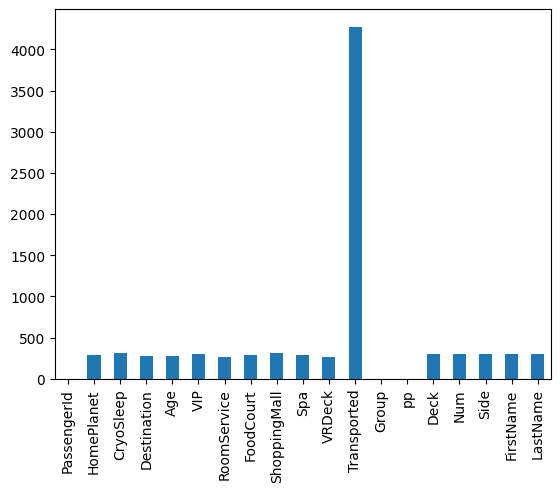

In [14]:
temp.isna().sum().plot(kind='bar')

In [15]:
get_number_of_null_cells_in_row(temp)

0    6606
1    4832
2    1012
3     354
4     140
5      24
6       2
dtype: int64

Approximately ~25% rows include null values that must be filled in.

<AxesSubplot: ylabel='Transported'>

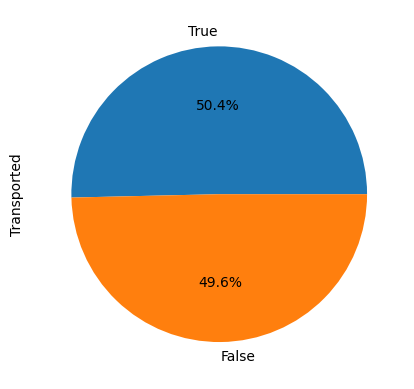

In [16]:
temp['Transported'].value_counts().plot(kind='pie', autopct='%1.1f%%')

As we can see train dataset is almost perfectly balanced.

### **2.1.1 Age --> Other**

In [17]:
temp

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Group,pp,Deck,Num,Side,FirstName,LastName
0,0001_01,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,0001,01,B,0,P,Maham,Ofracculy
1,0002_01,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True,0002,01,F,0,S,Juanna,Vines
2,0003_01,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,0003,01,A,0,S,Altark,Susent
3,0003_02,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,0003,02,A,0,S,Solam,Susent
4,0004_01,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True,0004,01,F,1,S,Willy,Santantines
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,9266_02,Earth,True,TRAPPIST-1e,34.0,False,0.0,0.0,0.0,0.0,0.0,NaN,9266,02,G,1496,S,Jeron,Peter
4273,9269_01,Earth,False,TRAPPIST-1e,42.0,False,0.0,847.0,17.0,10.0,144.0,NaN,9269,01,NaN,NaN,NaN,Matty,Scheron
4274,9271_01,Mars,True,55 Cancri e,NaN,False,0.0,0.0,0.0,0.0,0.0,NaN,9271,01,D,296,P,Jayrin,Pore
4275,9273_01,Europa,False,NaN,NaN,False,0.0,2680.0,0.0,0.0,523.0,NaN,9273,01,D,297,P,Kitakan,Conale


<function matplotlib.pyplot.show(close=None, block=None)>

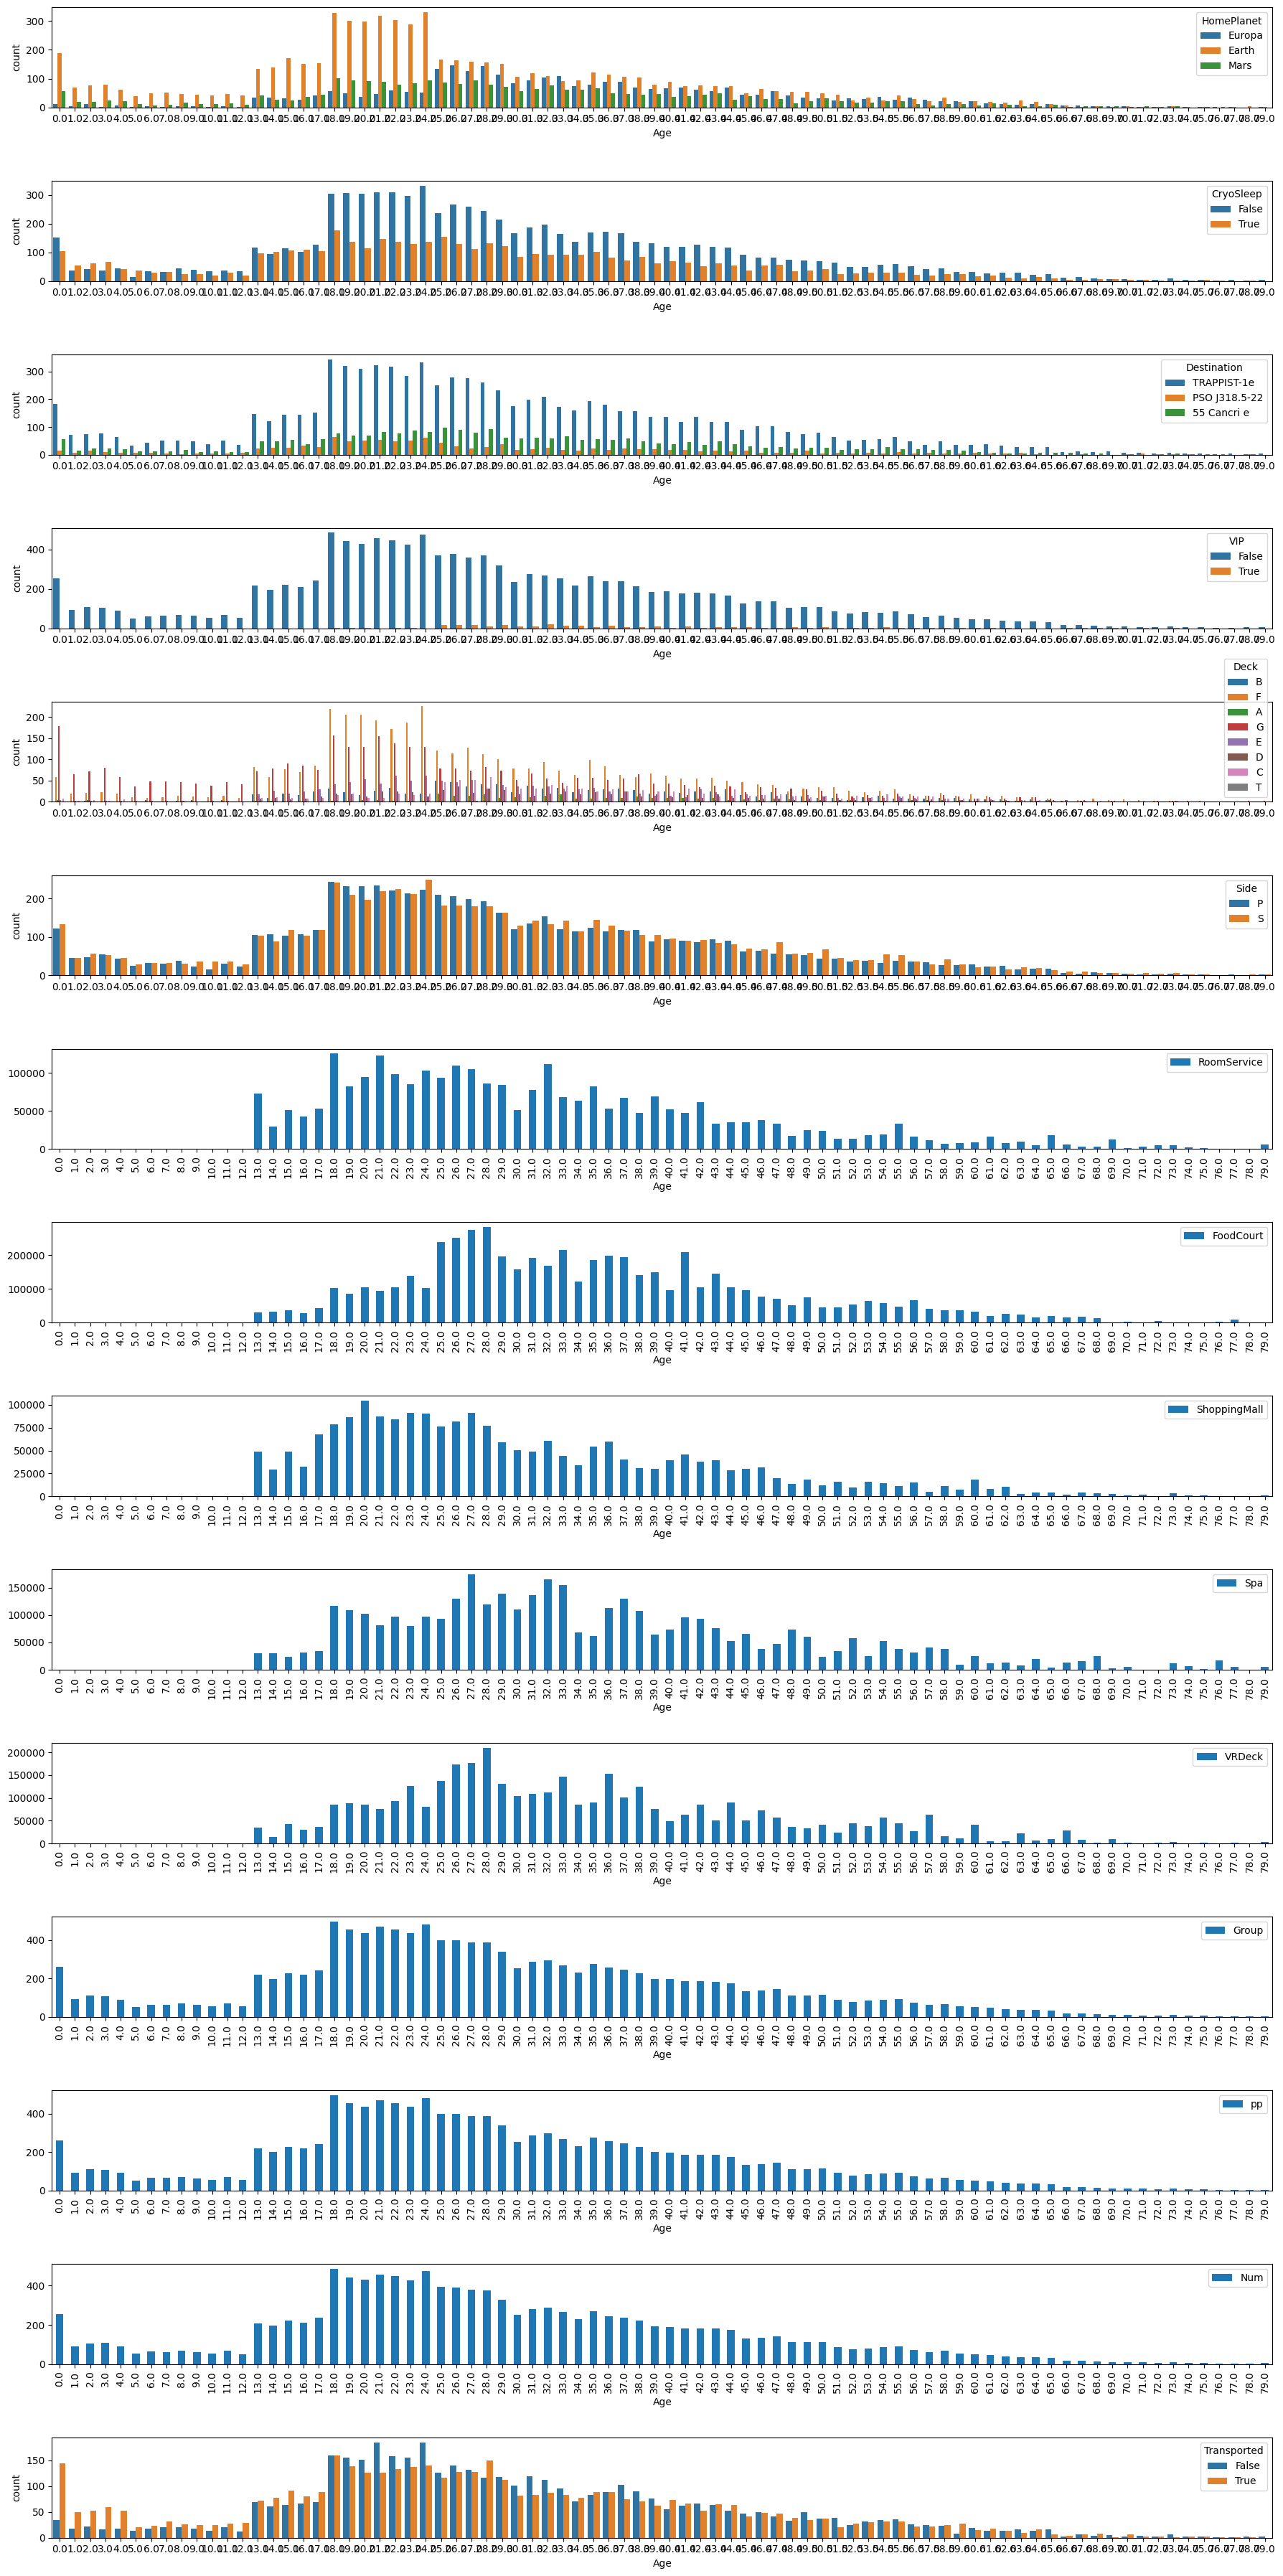

In [18]:
fig, ax = plt.subplots(15,figsize=(18,36))
sns.countplot(x='Age',hue='Transported',data=temp, ax=ax[14])
sns.countplot(x='Age',hue='HomePlanet',data=temp, ax=ax[0])
sns.countplot(x='Age',hue='CryoSleep',data=temp, ax=ax[1])
sns.countplot(x='Age',hue='Destination',data=temp, ax=ax[2])
sns.countplot(x='Age',hue='VIP',data=temp, ax=ax[3])
sns.countplot(x='Age',hue='Deck',data=temp, ax=ax[4])
sns.countplot(x='Age',hue='Side',data=temp, ax=ax[5])

temp.groupby('Age')['RoomService'].sum().plot(kind='bar', ax=ax[6], legend=True)
temp.groupby('Age')['FoodCourt'].sum().plot(kind='bar', ax=ax[7], legend=True)
temp.groupby('Age')['ShoppingMall'].sum().plot(kind='bar', ax=ax[8], legend=True)
temp.groupby('Age')['Spa'].sum().plot(kind='bar', ax=ax[9], legend=True)
temp.groupby('Age')['VRDeck'].sum().plot(kind='bar', ax=ax[10], legend=True)
temp.groupby('Age')['Group'].count().plot(kind='bar', ax=ax[11], legend=True)
temp.groupby('Age')['pp'].count().plot(kind='bar', ax=ax[12], legend=True)
temp.groupby('Age')['Num'].count().plot(kind='bar', ax=ax[13], legend=True)
fig.tight_layout()
plt.show

Age is a continuous feature were necessery is discretization which I do grouping some ages basing on visualization above.<br>
Groups:<br>
0 - age equal 0 many unborns/newborns was transported it might have impact for future training. <br>
1 - age 1-4 high transportation ratio <br>
2 - age 5-12 low count of persons in those age group i compare to other<br>
3 - age 13-17 the first group in which expenses appear<br>
4 - age 18-24 up to 24 age old only 4 VIP exist<br>
5 - age 25-65 others<br>
6 - age 66- count of persons above 66 years old is highly decrased

In [19]:
def group_age(df):
    df['Age'] = pd.cut(df['Age'], bins=[0,1,5,13,18,25,66,110], labels=[0,1,2,3,4,5,6], right=False)
    return df

### **2.1.2 HomePlanet --> other**

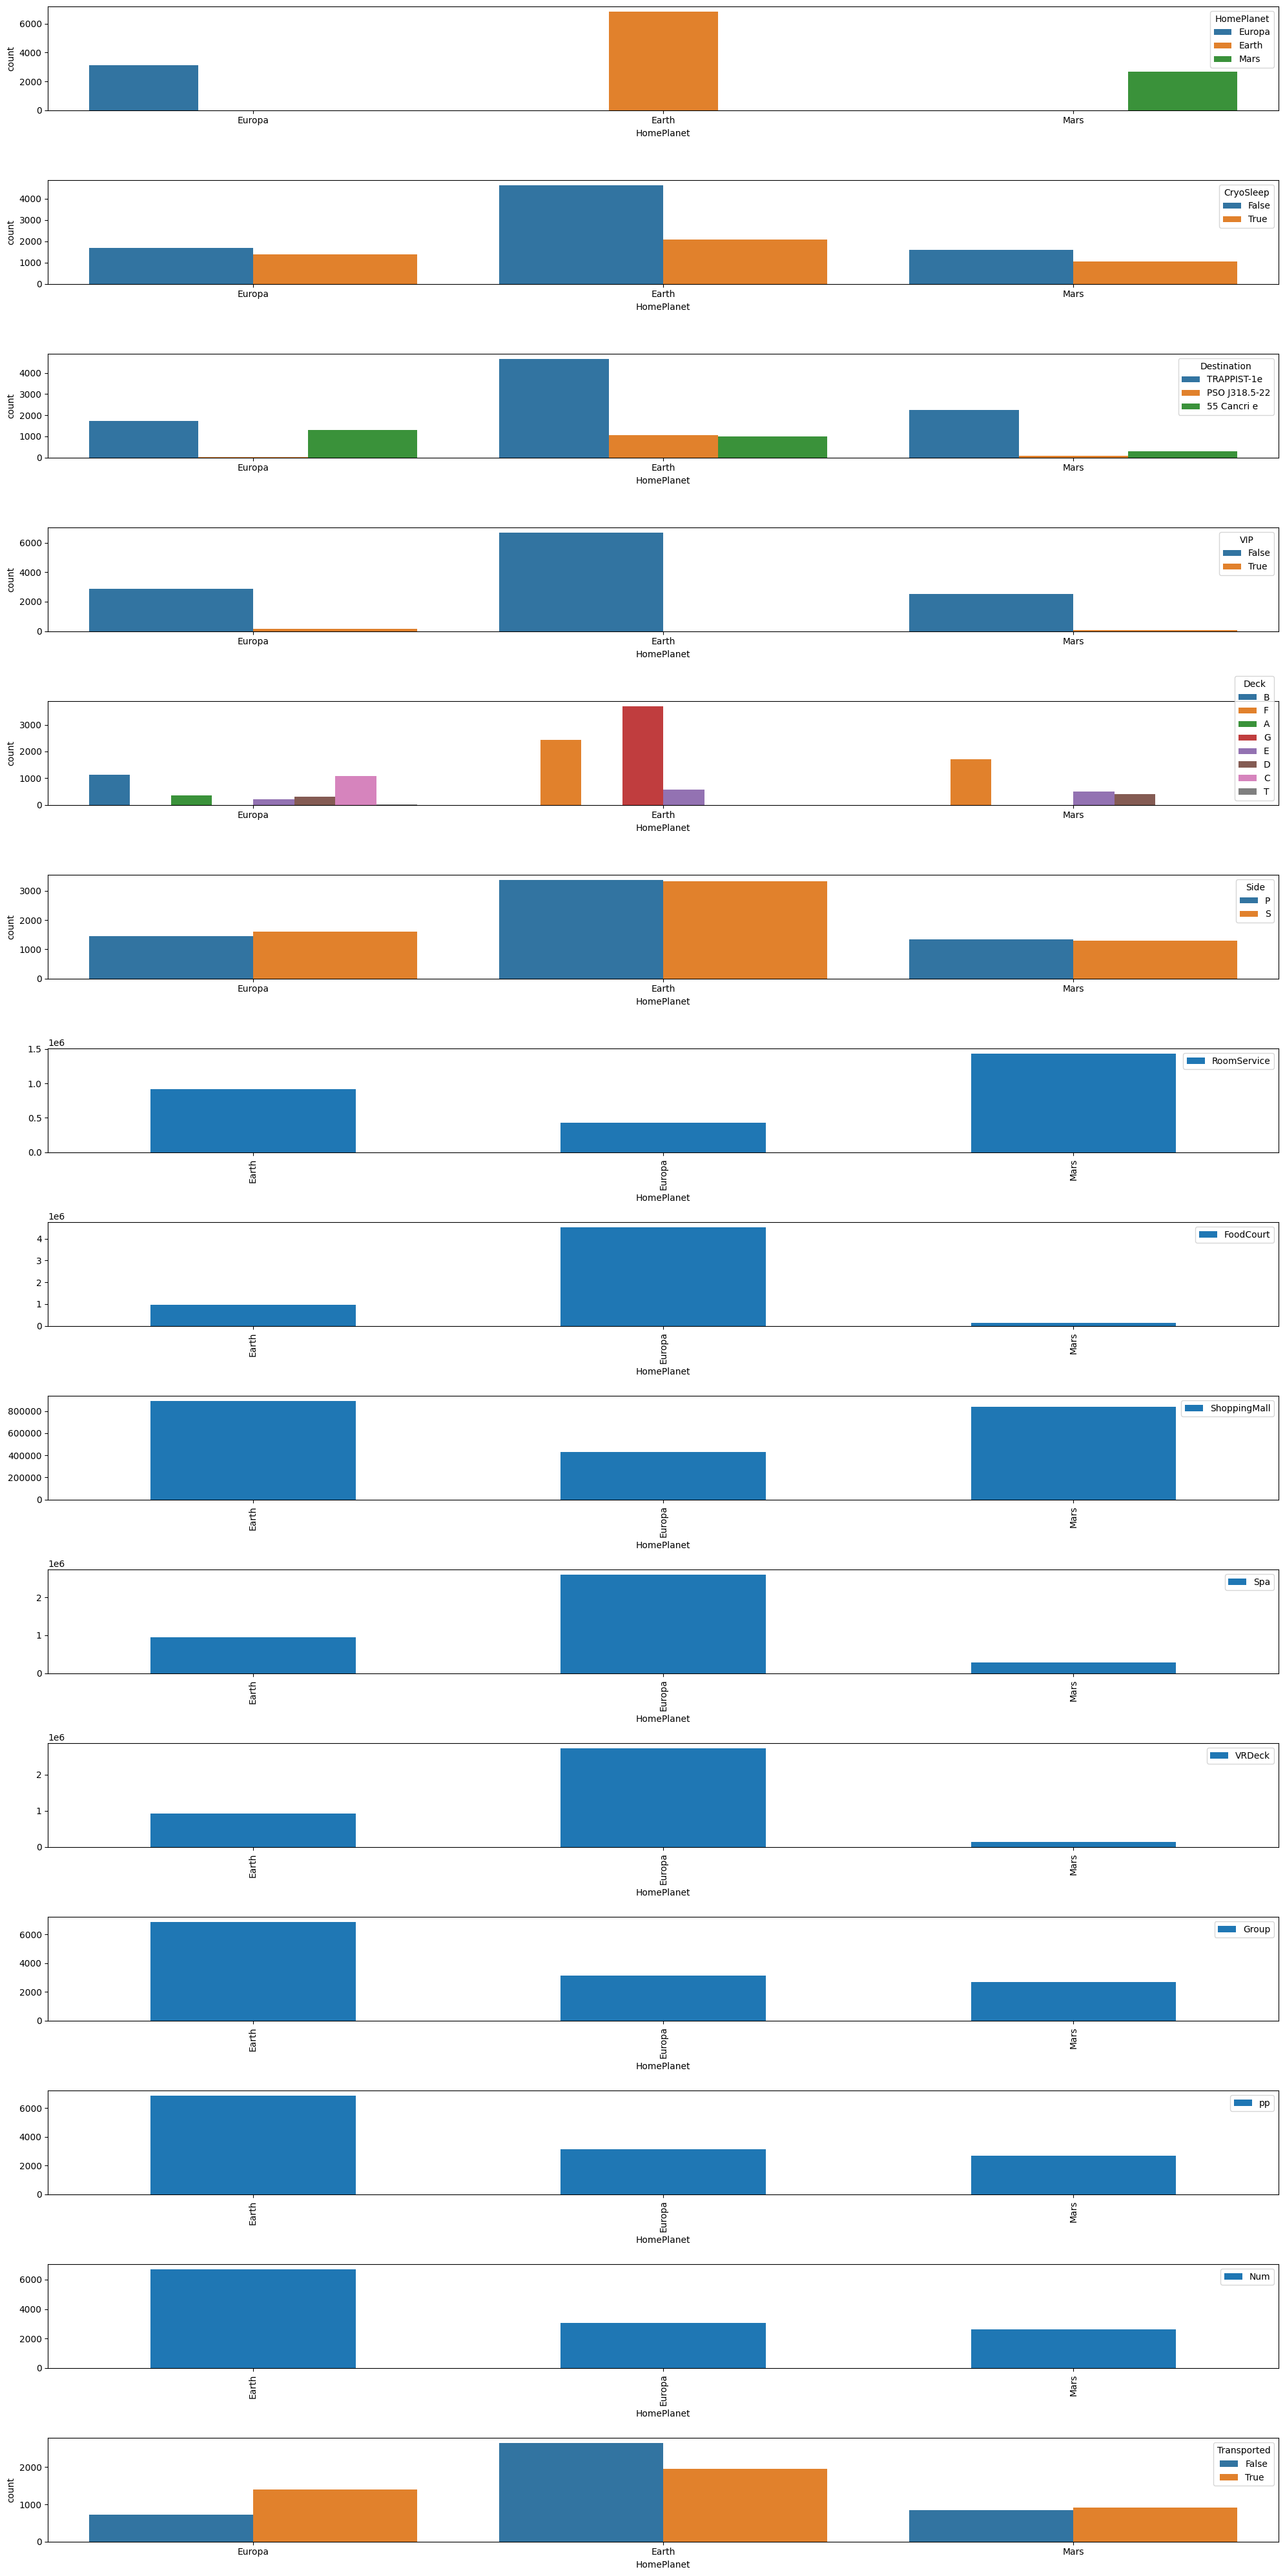

In [20]:
fig, ax = plt.subplots(15,figsize=(20,40))
sns.countplot(x='HomePlanet',hue='Transported',data=temp, ax=ax[14])
sns.countplot(x='HomePlanet',hue='HomePlanet',data=temp, ax=ax[0])
sns.countplot(x='HomePlanet',hue='CryoSleep',data=temp, ax=ax[1])
sns.countplot(x='HomePlanet',hue='Destination',data=temp, ax=ax[2])
sns.countplot(x='HomePlanet',hue='VIP',data=temp, ax=ax[3])
sns.countplot(x='HomePlanet',hue='Deck',data=temp, ax=ax[4])
sns.countplot(x='HomePlanet',hue='Side',data=temp, ax=ax[5])

temp.groupby('HomePlanet')['RoomService'].sum().plot(kind='bar', ax=ax[6], legend=True)
temp.groupby('HomePlanet')['FoodCourt'].sum().plot(kind='bar', ax=ax[7], legend=True)
temp.groupby('HomePlanet')['ShoppingMall'].sum().plot(kind='bar', ax=ax[8], legend=True)
temp.groupby('HomePlanet')['Spa'].sum().plot(kind='bar', ax=ax[9], legend=True)
temp.groupby('HomePlanet')['VRDeck'].sum().plot(kind='bar', ax=ax[10], legend=True)
temp.groupby('HomePlanet')['Group'].count().plot(kind='bar', ax=ax[11], legend=True)
temp.groupby('HomePlanet')['pp'].count().plot(kind='bar', ax=ax[12], legend=True)
temp.groupby('HomePlanet')['Num'].count().plot(kind='bar', ax=ax[13], legend=True)
fig.tight_layout()
plt.show()

In [21]:
temp[(temp.VIP == True) & (temp.HomePlanet == 'Earth')]

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Group,pp,Deck,Num,Side,FirstName,LastName


In [22]:
temp[(temp.Destination == 'PSO J318.5-22') & (temp.HomePlanet == 'Europa')].shape

(29, 19)

In [23]:
temp.groupby('HomePlanet')['Deck'].unique()

HomePlanet
Earth              [F, G, nan, E]
Europa    [B, A, C, D, nan, E, T]
Mars               [F, D, E, nan]
Name: Deck, dtype: object

Important information which can help fill `nan` is that no one from Earth get VIP status also only passengers from Earth get 'G' Deck and from Europa Decks 'B', 'A', 'C'<br>

For only 29 passengers out of about 2000 departure from Europa,the destination is PSO J318.5-22

### **2.1.3 VIP --> expenses**

In [24]:
temp['Expenses'] = temp['RoomService'] +temp['FoodCourt'] + temp['ShoppingMall'] + temp['Spa'] + temp['VRDeck']

<AxesSubplot: xlabel='VIP'>

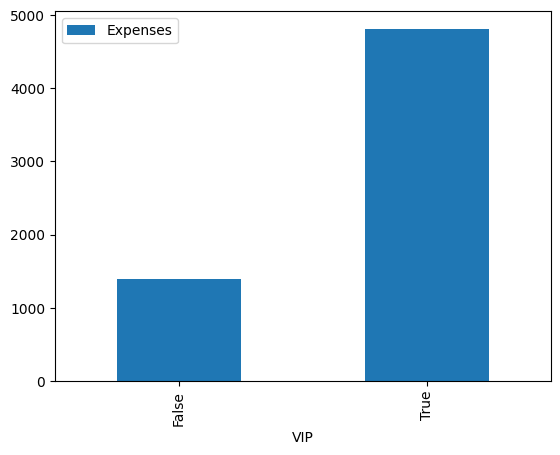

In [25]:
temp.groupby('VIP')['Expenses'].mean().plot(kind='bar', legend=True)

As we can see on `Age` and `HomePlanet` charts, the specific bill information does not give specific results therefore it will be collected into one column.<br>

`Expenses` `nan` can be filled by mean of expenses depending on VIP status

In [26]:
EXPENSES_COLUMNS = ['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']
def combine_expenses(df):
    df['Expenses'] = 0
    for column in EXPENSES_COLUMNS:
        df['Expenses'] = df['Expenses'] + df[column]
    #temp.drop(EXPENSES_COLUMNS, axis=1, inplace=True)
    return df

### **2.1.4 CryoSleep**

<AxesSubplot: xlabel='CryoSleep'>

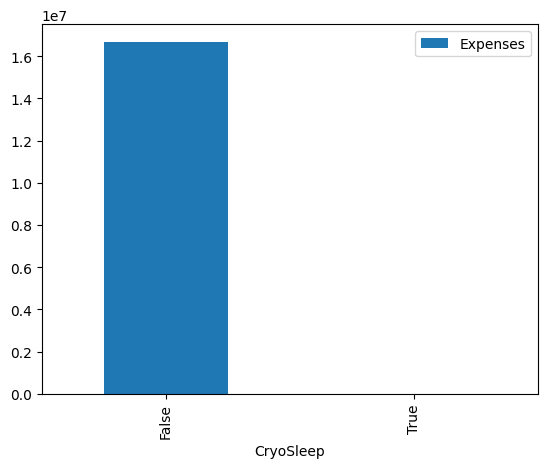

In [27]:
temp.groupby('CryoSleep')['Expenses'].sum().plot(kind='bar', legend=True)

In [28]:
temp[(temp.CryoSleep == True) & (temp.VIP == True)]

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Group,pp,Deck,Num,Side,FirstName,LastName,Expenses
365,0402_01,NaN,True,55 Cancri e,32.0,True,0.0,0.0,0.0,0.0,0.0,True,0402,01,D,15,S,Teron,Sageng,0.0
589,0612_01,Europa,True,TRAPPIST-1e,27.0,True,0.0,0.0,0.0,0.0,0.0,True,0612,01,B,25,P,Achyon,Ranaly,0.0
1849,1976_03,Europa,True,55 Cancri e,26.0,True,0.0,0.0,0.0,0.0,0.0,True,1976,03,B,82,S,Cellah,Lansuffle,0.0
2394,2572_02,Europa,True,55 Cancri e,56.0,True,0.0,0.0,0.0,0.0,0.0,True,2572,02,C,93,S,Spuri,Suptibler,0.0
2675,2866_01,Europa,True,TRAPPIST-1e,36.0,True,0.0,0.0,0.0,0.0,0.0,True,2866,01,C,110,S,Hadirk,Wheededly,0.0
3104,3349_01,Europa,True,TRAPPIST-1e,73.0,True,0.0,0.0,0.0,NaN,0.0,True,3349,01,C,111,P,Sargin,Brakeril,NaN
4071,4348_01,Europa,True,TRAPPIST-1e,47.0,True,0.0,0.0,0.0,0.0,0.0,True,4348,01,B,142,P,Krazet,Conate,0.0
4155,4441_01,Europa,True,55 Cancri e,31.0,True,0.0,0.0,0.0,0.0,0.0,True,4441,01,B,144,P,Kabiton,Clinarfork,0.0
4401,4668_02,Europa,True,55 Cancri e,27.0,True,0.0,0.0,0.0,0.0,0.0,True,4668,02,C,180,S,Sadrus,Scerodbox,0.0
4503,4786_01,Europa,True,TRAPPIST-1e,46.0,True,0.0,0.0,0.0,0.0,0.0,True,4786,01,B,160,P,Enibah,Dratembid,0.0


Passengers in `CryoSleep` have no expenses and if they travel from `Europa` are VIP. 

### **2.1.5 Outliers**

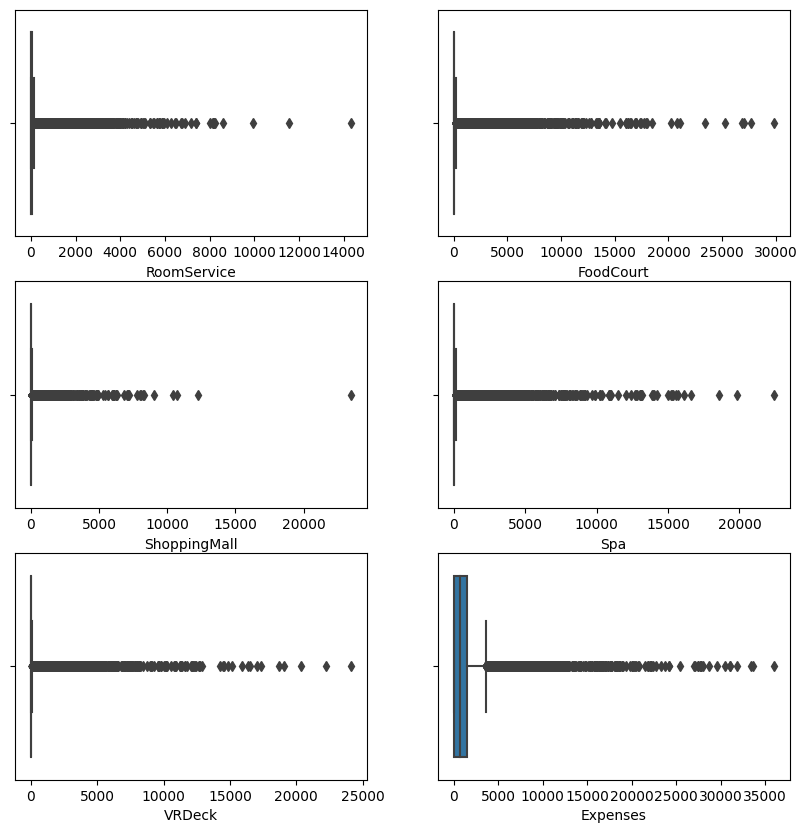

In [29]:
plt.figure(figsize=(10,10))
for i, feature in enumerate(EXPENSES_COLUMNS + ["Expenses"]):
    plt.subplot(3,2,i+1)
    sns.boxplot(x = temp[feature])


In [30]:
print(temp['RoomService'].mean())
print(temp[temp['RoomService'] > 0]['RoomService'].median())

222.89785157787045
313.5


In [31]:
print(temp['FoodCourt'].mean())
print(temp[temp['FoodCourt'] > 0]['FoodCourt'].median())

451.96167494677076
402.0


In [32]:
print(temp['ShoppingMall'].mean())
print(temp[temp['ShoppingMall'] > 0]['ShoppingMall'].median())

174.90603284902085
197.0


In [33]:
print(temp['Spa'].mean())
print(temp[temp['Spa'] > 0]['Spa'].median())

308.4769036733407
230.0


In [34]:
print(temp['VRDeck'].mean())
print(temp[temp['VRDeck'] > 0]['VRDeck'].median())

306.7894819713431
254.5


`Expenses` - due to many outliers `nan` will be filled by median

In [35]:
#TODO Check similar LastNames for HomePlanet 

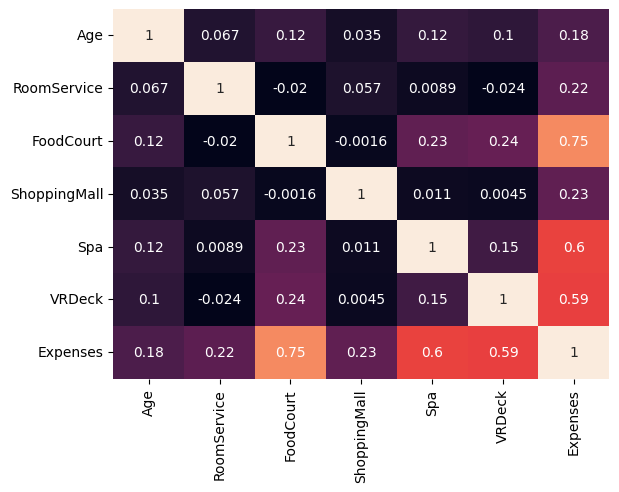

In [36]:
sns.heatmap(temp.corr(), annot=True, cbar=False)
plt.show()

## **2.2 Data cleaning**

#Describe steps based on previous analysis

In [37]:
train_test = pd.concat([train, test])

In [38]:
train_test = (train_test
              .pipe(split_cabin)
              .pipe(split_name)
              .pipe(split_passenger_id)
              )

In [39]:
train_test[train_test.duplicated()]

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Deck,Num,Side,FirstName,LastName,Group,pp


There is no duplicated rows between train and test set.

## **2.2.1 VIP**

In [40]:
train_test.VIP.isnull().sum()

296

In [41]:
train_test['VIP'] = np.where(train_test.VIP.isnull() & (train_test.Age < 25), False, train_test.VIP)

In [42]:
train_test['VIP'] = np.where(train_test.VIP.isnull() & train_test.HomePlanet.str.contains('Earth'), False, train_test.VIP)
train_test['VIP'] = np.where(train_test.VIP.isnull() & train_test.HomePlanet.str.contains('Europa'), True, train_test.VIP)

In [43]:
train_test.VIP.isnull().sum()

44

## **2.2.2 HomePlanet**

In [44]:
#group_age after fill nans

In [45]:
train_test.HomePlanet.isnull().sum()

288

In [46]:
train_test['HomePlanet'] = np.where(train_test.HomePlanet.isnull() & train_test.Deck.str.contains('G'), 'Earth', train_test.HomePlanet)

train_test['HomePlanet'] = np.where(train_test.HomePlanet.isnull() & train_test.Deck.str.contains('B'), 'Europa', train_test.HomePlanet)

train_test['HomePlanet'] = np.where(train_test.HomePlanet.isnull() & train_test.Deck.str.contains('A'), 'Europa', train_test.HomePlanet)

train_test['HomePlanet'] = np.where(train_test.HomePlanet.isnull() & train_test.Deck.str.contains('C'), 'Europa', train_test.HomePlanet)

train_test['HomePlanet'] = np.where(train_test.HomePlanet.isnull() & train_test.VIP & train_test.Deck.str.contains('F'), 'Mars', train_test.HomePlanet)

train_test['HomePlanet'] = np.where(train_test.HomePlanet.isnull() & (train_test.VIP==False), 'Earth', train_test.HomePlanet)

train_test['HomePlanet'] = np.where(train_test.HomePlanet.isnull() & train_test.CryoSleep & train_test.VIP, 'Europa', train_test.HomePlanet)

In [47]:
train_test.HomePlanet.isnull().sum()

3

There is still 2 `nan` where just 1 is from test set

## **2.2.3 Expenses**

In [48]:
for column in EXPENSES_COLUMNS:
    if_VIP_true = train_test[(train_test[column] > 0) & (train_test.VIP)][column].median()
    if_VIP_false = train_test[(train_test[column] > 0) & (train_test.VIP == False)][column].median()
    train_test[column] = np.where(train_test[column].isnull() & train_test.CryoSleep, 0, train_test[column])
    train_test[column] = np.where((train_test[column].isnull() )& (train_test.Age < 13), 0, train_test[column])
    train_test[column] = np.where(train_test[column].isnull() & (train_test.CryoSleep == False) & train_test.VIP, if_VIP_true, train_test[column])
    train_test[column] = np.where(train_test[column].isnull() & (train_test.CryoSleep == False), if_VIP_false, train_test[column])

In [49]:
train_test = combine_expenses(train_test)

In [50]:
train_test.Expenses.isnull().sum()

23

## **2.2.4 CryoSleep**

In [51]:
train_test.CryoSleep.isnull().sum()

310

In [52]:
train_test['CryoSleep'] = np.where(train_test.CryoSleep.isnull() & (train_test.Expenses == 0), True, train_test.CryoSleep)
train_test['CryoSleep'] = np.where(train_test.CryoSleep.isnull() & (train_test.Expenses > 0), False, train_test.CryoSleep)

In [53]:
train_test.CryoSleep.isnull().sum()

23

## **2.2.5 Age**

In [54]:
train_test.Age.isnull().sum()

270

In [55]:
median_without_expenses = train_test[(train_test.Age < 13)]['Age'].median()

In [56]:
median_with_expenses = train_test[(train_test.Age > 12)]['Age'].median()

In [57]:
train_test['Age'] = np.where(train_test.Age.isnull() & (train_test.Expenses == 0), median_without_expenses, train_test.Age)
train_test['Age'] = np.where(train_test.Age.isnull() & (train_test.Expenses > 0), median_with_expenses, train_test.Age)

In [58]:
train_test.Age.isnull().sum()

0

## **2.2.6 Destination**

No correlation found filled using `mode`

In [59]:
train_test.Destination.isnull().sum()

274

In [60]:
train_test['Destination'] = train_test.Destination.fillna(value=train_test.Destination.mode()[0])

In [61]:
train_test.Destination.isnull().sum()

0

In [62]:
#ProfileReport(train, title='Spaceship Titanic').to_file('Spaceship_Titanic.html')

## **2.2.7 Deck/Num/Side**

In [63]:
train_test.Deck.isnull().sum()

299

Number of `nan` in `Side` and `Num` is same because was created from one feature as `Deck` <br>
First I will try restore `Deck` values from `HomePlanet` were was 'G' for 'Earth' and 'B','A', 'C' for 'Europa' <br>

**Deck**

In [64]:
train_test[train_test.Deck.isnull()]

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Deck,Num,Side,FirstName,LastName,Group,pp,Expenses
15,0012_01,Earth,False,TRAPPIST-1e,31.0,False,32.0,0.0,876.0,0.0,0.0,False,NaN,NaN,NaN,Justie,Pooles,0012,01,908.0
93,0101_01,Mars,True,TRAPPIST-1e,31.0,False,0.0,0.0,0.0,0.0,0.0,True,NaN,NaN,NaN,Book,Trad,0101,01,0.0
103,0110_01,Europa,False,TRAPPIST-1e,32.0,False,0.0,410.0,6.0,3929.0,764.0,False,NaN,NaN,NaN,Graviph,Aloubtled,0110,01,5109.0
222,0239_01,Mars,False,TRAPPIST-1e,37.0,False,637.0,0.0,0.0,92.0,319.0,False,NaN,NaN,NaN,Diedow,Resty,0239,01,1048.0
227,0244_01,Mars,True,TRAPPIST-1e,43.0,False,0.0,0.0,0.0,0.0,0.0,True,NaN,NaN,NaN,Froos,Sad,0244,01,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4209,9138_01,Europa,False,TRAPPIST-1e,41.0,False,0.0,1998.0,0.0,1023.0,867.0,NaN,NaN,NaN,NaN,Misamak,Trupistic,9138,01,3888.0
4248,9223_01,Mars,True,TRAPPIST-1e,24.0,False,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,Weessh,Sun,9223,01,0.0
4249,9223_02,Mars,True,TRAPPIST-1e,17.0,False,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,Perit,Sun,9223,02,0.0
4258,9238_05,Earth,True,TRAPPIST-1e,14.0,False,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,Caseye,Emenez,9238,05,0.0


In [65]:
train_test.groupby(['HomePlanet', 'VIP', 'Deck'])['Destination'].count()

HomePlanet  VIP    Deck
Earth       False  D         16
                   E        617
                   F       2522
                   G       3780
                   T          1
Europa      False  A        300
                   B       1061
                   C       1020
                   D        282
                   E        191
                   T          9
            True   A         54
                   B         80
                   C         82
                   D         15
                   E          6
                   T          1
Mars        False  D        369
                   E        478
                   F       1653
            True   D         29
                   E         22
                   F         41
Name: Destination, dtype: int64

Most common `Deck` for 'Mars' is 'F' that is why I decide to fill rest of `nan` by 'F'

In [66]:
train_test['Deck'] = np.where(train_test.Deck.isnull() & train_test.HomePlanet.str.contains('Earth'), 'G', train_test.Deck)
train_test['Deck'] = np.where(train_test.Deck.isnull() & train_test.HomePlanet.str.contains('Europa'), 'B', train_test.Deck)
train_test['Deck'] = np.where(train_test.Deck.isnull() & train_test.HomePlanet.str.contains('Mars'), 'F', train_test.Deck)

In [67]:
train_test.Deck.isnull().sum()

0

**Num**

`Num` will be filled based on

In [68]:
train_test.Num.isnull().sum()

299

`num` and `Side` are same when `Group` and `LastName` are same

In [69]:
train_test['Num'] = np.where(train_test.Num.isnull() & train_test.LastName.eq(train_test.LastName.shift()), train_test.Num.shift(), train_test.Num)
train_test['Side'] = np.where(train_test.Side.isnull() & train_test.LastName.eq(train_test.LastName.shift()), train_test.Side.shift(), train_test.Side)

In [70]:
print(train_test.Num.isnull().sum())
print(train_test.Side.isnull().sum())

231
231


Other `nan` will be made up `mode` function

In [71]:
train_test['Num'] = train_test.Num.fillna(value=train_test.Num.mode()[0])
train_test['Side'] = train_test.Side.fillna(value=train_test.Side.mode()[0])

## **2.2.8 LastName**

In [72]:
train_test['LastName'] = np.where(train_test.LastName.isnull(), train_test.LastName.shift(), train_test.LastName)


In [73]:
train_test.LastName.isnull().sum()

11

## **2.2.9 Repeat steps**
Repetition of the steps is necessary because on the `nan` completed in the next steps were the basis for filling in the previous gaps.

**VIP**

In [74]:
train_test['VIP'] = np.where(train_test.VIP.isnull() & (train_test.Age < 25), False, train_test.VIP)
train_test['VIP'] = np.where(train_test.VIP.isnull() & train_test.HomePlanet.str.contains('Earth'), False, train_test.VIP)

**HomePlanet**

In [75]:
train_test['HomePlanet'] = np.where(train_test.HomePlanet.isnull() & train_test.Deck.str.contains('G'), 'Earth', train_test.HomePlanet)

train_test['HomePlanet'] = np.where(train_test.HomePlanet.isnull() & train_test.Deck.str.contains('B'), 'Europa', train_test.HomePlanet)

train_test['HomePlanet'] = np.where(train_test.HomePlanet.isnull() & train_test.Deck.str.contains('A'), 'Europa', train_test.HomePlanet)

train_test['HomePlanet'] = np.where(train_test.HomePlanet.isnull() & train_test.Deck.str.contains('C'), 'Europa', train_test.HomePlanet)

train_test['HomePlanet'] = np.where(train_test.HomePlanet.isnull() & train_test.VIP & train_test.Deck.str.contains('F'), 'Mars', train_test.HomePlanet)

train_test['HomePlanet'] = np.where(train_test.HomePlanet.isnull() & (train_test.VIP==False), 'Earth', train_test.HomePlanet)

train_test['HomePlanet'] = np.where(train_test.HomePlanet.isnull() & train_test.CryoSleep & train_test.VIP, 'Europa', train_test.HomePlanet)

**Expenses**

In [76]:
for column in EXPENSES_COLUMNS:
    if_VIP_true = train_test[(train_test[column] > 0) & (train_test.VIP)][column].median()
    if_VIP_false = train_test[(train_test[column] > 0) & (train_test.VIP == False)][column].median()
    train_test[column] = np.where(train_test[column].isnull() & train_test.CryoSleep, 0, train_test[column])
    train_test[column] = np.where((train_test[column].isnull() )& (train_test.Age < 13), 0, train_test[column])
    train_test[column] = np.where(train_test[column].isnull() & (train_test.CryoSleep == False) & train_test.VIP, if_VIP_true, train_test[column])
    train_test[column] = np.where(train_test[column].isnull() & (train_test.CryoSleep == False), if_VIP_false, train_test[column])

In [77]:
train_test = combine_expenses(train_test)

**CryoSleep**

In [78]:
train_test['CryoSleep'] = np.where(train_test.CryoSleep.isnull() & (train_test.Expenses == 0), True, train_test.CryoSleep)
train_test['CryoSleep'] = np.where(train_test.CryoSleep.isnull() & (train_test.Expenses > 0), False, train_test.CryoSleep)

<AxesSubplot: >

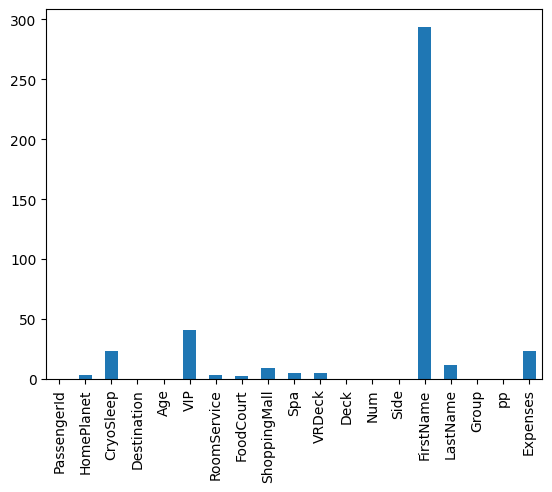

In [79]:
train_test.drop('Transported', axis=1).isna().sum().plot(kind='bar')

In [80]:
train_test.drop('FirstName', axis=1, inplace=True)

## **2.2.10 Drop `nan`**

In [81]:
get_number_of_null_cells_in_row(train_test.drop('Transported', axis=1))

0    12893
1       53
3       22
4        1
2        1
dtype: int64

`nan` in test set

In [82]:
get_number_of_null_cells_in_row(train_test[train_test.Transported.isnull()])

1    4251
2      21
4       5
dtype: int64

In [83]:
train = train_test[~train_test.Transported.isnull()].dropna().copy()
test = train_test[train_test.Transported.isnull()].copy()

In [84]:
get_number_of_null_cells_in_row(train)

0    8642
dtype: int64

1841 rows has been restored by filling `nan` in train dataset

## **2.3 Feature Engineering**

In [85]:
train_test = pd.concat([train, test])

In [86]:
train_test.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Destination', 'Age', 'VIP',
       'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Transported', 'Deck', 'Num', 'Side', 'LastName', 'Group', 'pp',
       'Expenses'],
      dtype='object')

In [87]:
train_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12919 entries, 0 to 4276
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   12919 non-null  object 
 1   HomePlanet    12918 non-null  object 
 2   CryoSleep     12914 non-null  object 
 3   Destination   12919 non-null  object 
 4   Age           12919 non-null  float64
 5   VIP           12906 non-null  object 
 6   RoomService   12918 non-null  float64
 7   FoodCourt     12919 non-null  float64
 8   ShoppingMall  12917 non-null  float64
 9   Spa           12918 non-null  float64
 10  VRDeck        12918 non-null  float64
 11  Transported   8642 non-null   object 
 12  Deck          12919 non-null  object 
 13  Num           12919 non-null  object 
 14  Side          12919 non-null  object 
 15  LastName      12912 non-null  object 
 16  Group         12919 non-null  object 
 17  pp            12919 non-null  object 
 18  Expenses      12914 non-nul

In [88]:
 train_test = group_age(train_test)

In [89]:
train_test.VIP = train_test.VIP.replace({True : 1, False : 0})
train_test.CryoSleep = train_test.CryoSleep.replace({True : 1, False : 0})
train_test.Side = train_test.Side.replace({'P' : 1, 'S' : 0})
#train_test.Transported = train_test.Transported.astype('bool') 

In [90]:
categorical = ['Age', 'Num', 'Group', 'LastName', 'pp']
for column in categorical:
    encoder = LabelEncoder()
    train_test[column] = encoder.fit_transform(train_test[column])

In [91]:
train_test = pd.get_dummies(train_test, columns=['HomePlanet', 'Destination', 'Deck'])

In [92]:
train_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12919 entries, 0 to 4276
Data columns (total 30 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   PassengerId                12919 non-null  object 
 1   CryoSleep                  12914 non-null  float64
 2   Age                        12919 non-null  int64  
 3   VIP                        12906 non-null  float64
 4   RoomService                12918 non-null  float64
 5   FoodCourt                  12919 non-null  float64
 6   ShoppingMall               12917 non-null  float64
 7   Spa                        12918 non-null  float64
 8   VRDeck                     12918 non-null  float64
 9   Transported                8642 non-null   object 
 10  Num                        12919 non-null  int64  
 11  Side                       12919 non-null  int64  
 12  LastName                   12919 non-null  int64  
 13  Group                      12919 non-null  int6

## **2.3.1 Data splitting**

In [93]:
train_test.reset_index(drop=True, inplace=True)
train = train_test[~train_test.Transported.isnull()].copy().astype('float64')
test = train['Transported'].copy().astype('float64')
train = train.drop(labels=['PassengerId', 'Transported'], axis=1)
submission_test = train_test[train_test.Transported.isnull()].copy()
submission = submission_test.PassengerId.copy()
submission_test = submission_test.drop(labels =['PassengerId', 'Transported'], axis=1)

In [94]:
X_train, X_test,y_train, y_test = train_test_split(train,test, test_size=0.2, shuffle=True, random_state=42)

X_train, X_val,y_train, y_val = train_test_split(X_train,y_train, test_size=0.2,shuffle=True, random_state=42)

## **2.3.2 Data Normalization**

In [95]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

<AxesSubplot: ylabel='Transported'>

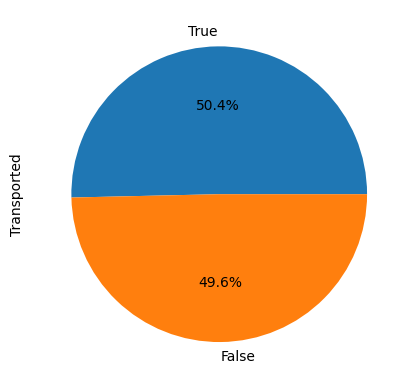

In [96]:
train_test[~train_test.Transported.isnull()]['Transported'].value_counts().plot(kind='pie', autopct='%1.1f%%')

After data cleaning dataset balance stay same as before

# **3.Models**

The algorithms it will use:<br>
    XGBoost<br>
    LightGBM<br>
    CatBoost<br>
    
Neural Network:<br>
    PyTorch logistic regression

## **3.1 Machine Learning algorithms**

## **3.1.1 XGBoost**

In [97]:
#Based on histograms slower than other

In [98]:
xgbc = xgb.XGBClassifier()
xgbc.fit(train, test)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

Text(0.5, 0, 'Importance [%]')

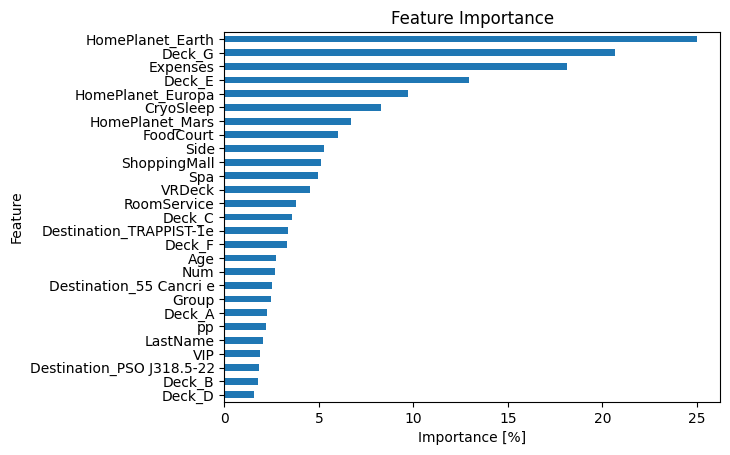

In [99]:
#Future importance by whole train dataset
feature_importance = xgbc.get_booster().get_score(importance_type='gain')

importance = pd.DataFrame({'Feature' : train.columns[0:-1], "Importance" :feature_importance.values()})
importance.groupby('Feature')["Importance"].sum().sort_values().plot(kind='barh')
plt.title('Feature Importance')
plt.xlabel("Importance [%]")

In [100]:
importance = importance.sort_values('Importance',ascending= False)

In [101]:
#loss function and evaluation metric serve two different purposes. 
#The loss function is used by the model to learn the relationship between input and output. 
#The evaluation metric is used to assess how good the learned relationship is. 
#Here is a link to a discussion of model https://scikit-learn.org/stable/modules/model_evaluation.html

In [102]:
def objective(trial):

    params = {
        #Parameters to tune
        'n_estimators': trial.suggest_int('n_estimators', 50, 3000),
        'max_depth': trial.suggest_int('max_depth', 1, 20),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 20),
        
        #Parameters for faster speed
        'colsample_bytree' : trial.suggest_loguniform('colsample_bytree', 0.01, 1.0),
        'subsample': trial.suggest_loguniform('subsample', 0.01, 1.0),
        
        #Parameters to control overfitting
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
        'gamma': trial.suggest_loguniform('gamma',1, 10),
        
        #Regularizers for bigger dataset
        #'alpha' : trial.suggest_int('alpha', 0, 5),
        #'lambda' : trial.suggest_int('lambda', 1, 5),
        
        #Loss function and evaluation metric
        'objective' : 'binary:logistic', # represents cross entropy loss function
        'eval_metric': 'auc', #according to objective when used with binary classification objective should be 'binary:logistic'
        
        #'tree_method' : 'gpu_hist' 
    
    }
    
    
    # Fit the model
    optuna_model = xgb.XGBClassifier(**params)
    optuna_model.fit(X_train, y_train, verbose=False, eval_set=[(X_val, y_val)], early_stopping_rounds=10)

    # Make predictions
    y_pred = optuna_model.predict(X_test)

    # Evaluate predictions
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

In [103]:
%%time

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)
    
print('Number of finished trials: {}'.format(len(study.trials)))
print('Best trial:')
trial = study.best_trial

print('  Value: {}'.format(trial.value))
print('  Params: ')

for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

Number of finished trials: 200
Best trial:
  Value: 0.8253325621746674
  Params: 
    n_estimators: 2282
    max_depth: 9
    min_child_weight: 6
    colsample_bytree: 0.6925324385798847
    subsample: 0.9981443990850575
    learning_rate: 0.030204759102331058
    gamma: 7.328882907196085
CPU times: user 1h 51min 10s, sys: 33min 2s, total: 2h 24min 13s
Wall time: 19min 35s


In [104]:
0.8178

0.8178

In [105]:
#Checking accurancy iterate over feature importance

# %%time
# for i in range(len(importance['Feature'])):
#     features = importance.iloc[:i+1,0]
#     feature_train = X_train[:,:i+1]
#     feature_test = X_test[:,:i+1]
#     print(f'Training features:{i+1}')
#     for j in features:
#         print(j, end=' ')
#     study = optuna.create_study(direction='maximize')
#     study.optimize(objective, n_trials=100, n_jobs=-1)
    
#     print('\nNumber of finished trials: {}'.format(len(study.trials)))
#     print('Best trial:')
#     trial = study.best_trial

#     print('  Value: {}'.format(trial.value))
#     print('  Params: ')

#     for key, value in trial.params.items():
#         print('    {}: {}'.format(key, value))
#     print("---------------------------------------\n" )

In [106]:
%time
xgbc = xgb.XGBClassifier(**trial.params)
xgbc.fit(X_train, y_train) 

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 3.1 µs


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6925324385798847, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=7.328882907196085, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.030204759102331058, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=6, missing=nan, monotone_constraints=None,
              n_estimators=2282, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

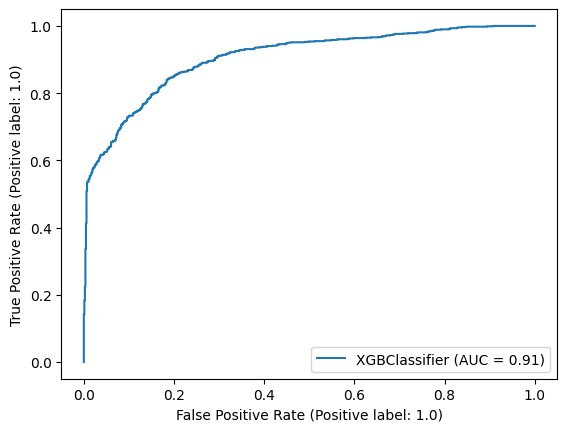

In [107]:
xgbc_roc = RocCurveDisplay.from_estimator(xgbc, X_test, y_test)

In [108]:
sub_pred_xgbc = xgbc.predict(submission_test)

sub_pred_xgbc = sub_pred_xgbc.astype('bool')

In [109]:
N_SPLITS = 10
kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=42)

scores = []

for train_idx, test_idx in kf.split(train):

    X_train, X_test = train.iloc[train_idx], train.iloc[test_idx]
    y_train, y_test = test[train_idx], test[test_idx]
    
    preds = xgbc.predict(X_test)
    loss = accuracy_score(y_test, preds)
    scores.append(loss)
    accuracy = np.mean(scores)
    
print(f"mean score: {accuracy}\n")

mean score: 0.7360531738385785



## **3.1.2 LightGBM**

In [110]:
def objective(trial):

    params={
    #Parameters to tune
    'num_leaves' : trial.suggest_int('num_leaves',2,1000), #should be less than 2^max_depth lower better acc
    'max_depth' : trial.suggest_int('max_depth', 1, 15),
    'min_data_in_leaf' : trial.suggest_int('min_data_in_leaf', 0, 400),
    
    #Parameters for better accurancy
    'max_bin' : trial.suggest_int('max_bin',100,600), #small number of bins may reduce training accuracy 
                                                    #but may increase general power (deal with over-fitting)
    'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.5),
    
    #Parameters for faster speed and deal with over-fitting 
#     'feature_fraction' : trial.suggest_loguniform('feature_fraction', 0.01, 1.0),
#     'bagging_freq' : trial.suggest_int('bagging_freq', 1, 100),
#     'save_binary' : True,
    
    #Parameters to control over-fitting
    'min_gain_to_split' : trial.suggest_loguniform('min_gain_to_split', 1.0, 10.0),
    
    #Loss function and evaluation metric
    'objective' : 'binary', 
    'metric': 'auc', 
        
    #Regularizers
    #'lambda_l1' : trial.suggest_loguniform('lambda_l1', 0.01, 5.0),
    #'lambda_l2' : trial.suggest_loguniform('lambda_l2', 0.01, 5.0),
        
    'device_type' : 'CPU',
    'n_jobs' : -1,
    'verbosity' : -1
}
    
    
    # Fit the model
    optuna_model = lgbm.LGBMClassifier(**params)
    optuna_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping=10)

    # Make predictions
    y_pred = optuna_model.predict(X_test)

    # Evaluate predictions
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

In [111]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, n_jobs=-1)
    
print('Number of finished trials: {}'.format(len(study.trials)))
print('Best trial:')
trial = study.best_trial

print('  Value: {}'.format(trial.value))
print('  Params: ')

for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

[LightGBM] [Warning] min_data_in_leaf is set=361, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=361
[LightGBM] [Warning] min_gain_to_split is set=1.2034591656397797, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2034591656397797
[LightGBM] [Warning] min_data_in_leaf is set=113, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=113
[LightGBM] [Warning] min_gain_to_split is set=1.5763237493146034, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.5763237493146034
[LightGBM] [Warning] min_data_in_leaf is set=170, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=170
[LightGBM] [Warning] min_gain_to_split is set=9.8378771465554, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.8378771465554
[LightGBM] [Warning] min_data_in_leaf is set=312, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=312
[LightGBM] [Warning] min_gain_to_split is set=1.

[71]	valid_0's auc: 0.763706[12]	valid_0's auc: 0.721878

[50]	valid_0's auc: 0.725345
[41]	valid_0's auc: 0.685405
[20]	valid_0's auc: 0.706282
[42]	valid_0's auc: 0.685405
[54]	valid_0's auc: 0.733138
[72]	valid_0's auc: 0.763706
[51]	valid_0's auc: 0.725345
[43]	valid_0's auc: 0.685405
[73]	valid_0's auc: 0.763706
[44]	valid_0's auc: 0.685405
[55]	valid_0's auc: 0.733138
[45]	valid_0's auc: 0.685405
[52]	valid_0's auc: 0.725345
[74]	valid_0's auc: 0.763706
[46]	valid_0's auc: 0.685405
[56]	valid_0's auc: 0.733138
[75]	valid_0's auc: 0.763706
[47]	valid_0's auc: 0.685405
[53]	valid_0's auc: 0.725345
[48]	valid_0's auc: 0.685405
[57]	valid_0's auc: 0.733138
[76]	valid_0's auc: 0.763706
[21]	valid_0's auc: 0.708266
[54]	valid_0's auc: 0.725345
[49]	valid_0's auc: 0.685405
[13]	valid_0's auc: 0.718859
[77]	valid_0's auc: 0.759647
[58]	valid_0's auc: 0.733138
[50]	valid_0's auc: 0.685405
[9]	valid_0's auc: 0.695403
[51]	valid_0's auc: 0.685405
[78]	valid_0's auc: 0.7601
[55]	valid_0's au

[79]	valid_0's auc: 0.739613
[16]	valid_0's auc: 0.686696
[80]	valid_0's auc: 0.739613
[1]	valid_0's auc: 0.703462
[17]	valid_0's auc: 0.687188
[2]	valid_0's auc: 0.715134
[81]	valid_0's auc: 0.739613
[3]	valid_0's auc: 0.711309
[18]	valid_0's auc: 0.688941
[82]	valid_0's auc: 0.739613
[4]	valid_0's auc: 0.700086
[19]	valid_0's auc: 0.691377
[5]	valid_0's auc: 0.703215
[83]	valid_0's auc: 0.739613
[6]	valid_0's auc: 0.687779
[84]	valid_0's auc: 0.739613
[20]	valid_0's auc: 0.691893
[7]	valid_0's auc: 0.679044
[85]	valid_0's auc: 0.739613
[8]	valid_0's auc: 0.681618
[21]	valid_0's auc: 0.693442
[86]	valid_0's auc: 0.739613
[9]	valid_0's auc: 0.680637
[87]	valid_0's auc: 0.739613
[22]	valid_0's auc: 0.694663
[10]	valid_0's auc: 0.687462
[88]	valid_0's auc: 0.739613
[11]	valid_0's auc: 0.686222
[89]	valid_0's auc: 0.739613
[23]	valid_0's auc: 0.692897
[12]	valid_0's auc: 0.677768
[13]	valid_0's auc: 0.671888
[90]	valid_0's auc: 0.739613
[14]	valid_0's auc: 0.674668
[24]	valid_0's auc: 0.6

[47]	valid_0's auc: 0.735395
[39]	valid_0's auc: 0.708274
[16]	valid_0's auc: 0.722943
[4]	valid_0's auc: 0.704301
[48]	valid_0's auc: 0.730601
[49]	valid_0's auc: 0.730601
[3]	valid_0's auc: 0.712978
[50]	valid_0's auc: 0.730601
[19]	valid_0's auc: 0.666858
[5]	valid_0's auc: 0.701867
[17]	valid_0's auc: 0.723497
[40]	valid_0's auc: 0.708274
[51]	valid_0's auc: 0.730601
[52]	valid_0's auc: 0.730601
[32]	valid_0's auc: 0.682545
[6]	valid_0's auc: 0.704301
[53]	valid_0's auc: 0.730601
[18]	valid_0's auc: 0.71023
[4]	valid_0's auc: 0.712978
[20]	valid_0's auc: 0.668429
[41]	valid_0's auc: 0.708289
[54]	valid_0's auc: 0.728492
[7]	valid_0's auc: 0.701867
[19]	valid_0's auc: 0.723497
[21]	valid_0's auc: 0.669952
[59]	valid_0's auc: 0.730642
[33]	valid_0's auc: 0.682811
[42]	valid_0's auc: 0.708289
[20]	valid_0's auc: 0.71023
[22]	valid_0's auc: 0.667626
[60]	valid_0's auc: 0.730642
[21]	valid_0's auc: 0.71023
[43]	valid_0's auc: 0.70959
[8]	valid_0's auc: 0.701917
[23]	valid_0's auc: 0.670

[2]	valid_0's auc: 0.699065
[15]	valid_0's auc: 0.715047
[52]	valid_0's auc: 0.707519
[80]	valid_0's auc: 0.723311
[59]	valid_0's auc: 0.716682
[59]	valid_0's auc: 0.7364
[53]	valid_0's auc: 0.707519[3]	valid_0's auc: 0.699065

[81]	valid_0's auc: 0.723311
[43]	valid_0's auc: 0.687097
[16]	valid_0's auc: 0.715047
[4]	valid_0's auc: 0.699065
[60]	valid_0's auc: 0.730448
[60]	valid_0's auc: 0.718474
[54]	valid_0's auc: 0.707519
[82]	valid_0's auc: 0.723311
[61]	valid_0's auc: 0.730448
[5]	valid_0's auc: 0.703462
[61]	valid_0's auc: 0.718474
[55]	valid_0's auc: 0.707519
[17]	valid_0's auc: 0.715047
[62]	valid_0's auc: 0.730448
[44]	valid_0's auc: 0.688588
[83]	valid_0's auc: 0.723311
[6]	valid_0's auc: 0.708698
[63]	valid_0's auc: 0.731552
[56]	valid_0's auc: 0.707519
[62]	valid_0's auc: 0.718474
[7]	valid_0's auc: 0.708698
[84]	valid_0's auc: 0.723311
[18]	valid_0's auc: 0.715047
[64]	valid_0's auc: 0.731652
[57]	valid_0's auc: 0.707519
[45]	valid_0's auc: 0.690045
[63]	valid_0's auc: 0.

[98]	valid_0's auc: 0.740372
[82]	valid_0's auc: 0.722369
[82]	valid_0's auc: 0.710415
[34]	valid_0's auc: 0.725725
[99]	valid_0's auc: 0.740577
[35]	valid_0's auc: 0.725568
[100]	valid_0's auc: 0.740826
[36]	valid_0's auc: 0.725355
[83]	valid_0's auc: 0.722626
[37]	valid_0's auc: 0.725355
[38]	valid_0's auc: 0.725355
[39]	valid_0's auc: 0.734089
[40]	valid_0's auc: 0.725355[84]	valid_0's auc: 0.721622

[58]	valid_0's auc: 0.696345
[41]	valid_0's auc: 0.734089
[42]	valid_0's auc: 0.725836
[85]	valid_0's auc: 0.722745
[43]	valid_0's auc: 0.73457
[44]	valid_0's auc: 0.725836
[45]	valid_0's auc: 0.73457
[46]	valid_0's auc: 0.73457
[86]	valid_0's auc: 0.720478
[47]	valid_0's auc: 0.73457
[48]	valid_0's auc: 0.735097
[49]	valid_0's auc: 0.735179
[87]	valid_0's auc: 0.720639
[50]	valid_0's auc: 0.728894
[51]	valid_0's auc: 0.728998
[52]	valid_0's auc: 0.728998
[88]	valid_0's auc: 0.720269
[83]	valid_0's auc: 0.710083
[53]	valid_0's auc: 0.728998
[89]	valid_0's auc: 0.715318
[59]	valid_0's au

[34]	valid_0's auc: 0.710054
[12]	valid_0's auc: 0.680743
[34]	valid_0's auc: 0.711592
[59]	valid_0's auc: 0.675675
[95]	valid_0's auc: 0.724408
[35]	valid_0's auc: 0.710412
[13]	valid_0's auc: 0.684898
[35]	valid_0's auc: 0.705662
[18]	valid_0's auc: 0.75163
[36]	valid_0's auc: 0.713347
[60]	valid_0's auc: 0.687647
[8]	valid_0's auc: 0.694765
[14]	valid_0's auc: 0.67323
[36]	valid_0's auc: 0.708989
[37]	valid_0's auc: 0.714886
[22]	valid_0's auc: 0.695218
[15]	valid_0's auc: 0.671337
[37]	valid_0's auc: 0.708585
[61]	valid_0's auc: 0.687517
[38]	valid_0's auc: 0.7143
[16]	valid_0's auc: 0.682753
[38]	valid_0's auc: 0.708623
[62]	valid_0's auc: 0.687708
[9]	valid_0's auc: 0.704908
[39]	valid_0's auc: 0.715529
[39]	valid_0's auc: 0.71149
[17]	valid_0's auc: 0.683952
[63]	valid_0's auc: 0.688581
[18]	valid_0's auc: 0.684506
[40]	valid_0's auc: 0.712413
[40]	valid_0's auc: 0.715371
[19]	valid_0's auc: 0.671569
[41]	valid_0's auc: 0.709422
[41]	valid_0's auc: 0.713417
[64]	valid_0's auc: 0

[92]	valid_0's auc: 0.727473
[37]	valid_0's auc: 0.700602
[31]	valid_0's auc: 0.661037
[93]	valid_0's auc: 0.727473
[6]	valid_0's auc: 0.735511
[94]	valid_0's auc: 0.727473
[95]	valid_0's auc: 0.727473
[38]	valid_0's auc: 0.700672
[32]	valid_0's auc: 0.661887
[96]	valid_0's auc: 0.727473
[68]	valid_0's auc: 0.749045
[39]	valid_0's auc: 0.703067
[97]	valid_0's auc: 0.727473
[80]	valid_0's auc: 0.666383
[7]	valid_0's auc: 0.729169
[98]	valid_0's auc: 0.727473
[33]	valid_0's auc: 0.664911
[99]	valid_0's auc: 0.727473
[100]	valid_0's auc: 0.727473
[40]	valid_0's auc: 0.70367
[34]	valid_0's auc: 0.660544
[8]	valid_0's auc: 0.722629
[41]	valid_0's auc: 0.701777
[42]	valid_0's auc: 0.703473
[43]	valid_0's auc: 0.706639
[35]	valid_0's auc: 0.660471
[44]	valid_0's auc: 0.706536
[9]	valid_0's auc: 0.70305
[36]	valid_0's auc: 0.65896
[45]	valid_0's auc: 0.70812
[46]	valid_0's auc: 0.707321
[37]	valid_0's auc: 0.666294
[47]	valid_0's auc: 0.708197
[10]	valid_0's auc: 0.709661
[38]	valid_0's auc: 0

[12]	valid_0's auc: 0.695357
[26]	valid_0's auc: 0.70035
[64]	valid_0's auc: 0.704334
[7]	valid_0's auc: 0.70437
[13]	valid_0's auc: 0.698247
[27]	valid_0's auc: 0.701505[8]	valid_0's auc: 0.70437
[10]	valid_0's auc: 0.689165

[14]	valid_0's auc: 0.701662
[15]	valid_0's auc: 0.702732
[28]	valid_0's auc: 0.702996
[65]	valid_0's auc: 0.706377
[9]	valid_0's auc: 0.688949
[16]	valid_0's auc: 0.701893
[10]	valid_0's auc: 0.685165
[17]	valid_0's auc: 0.701753
[18]	valid_0's auc: 0.704407
[11]	valid_0's auc: 0.681932
[29]	valid_0's auc: 0.705859
[12]	valid_0's auc: 0.681932
[19]	valid_0's auc: 0.698338
[20]	valid_0's auc: 0.701775
[13]	valid_0's auc: 0.681212
[21]	valid_0's auc: 0.709569
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] min_gain_to_split is set=1.040212325598381, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.040212325598381
[14]	valid_0's auc: 0.682268
[22]	va

[LightGBM] [Warning] min_data_in_leaf is set=149, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=149
[LightGBM] [Warning] min_gain_to_split is set=1.0423308189511424, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0423308189511424
[42]	valid_0's auc: 0.709047
[15]	valid_0's auc: 0.689231
[19]	valid_0's auc: 0.69669
[3]	valid_0's auc: 0.699974
[8]	valid_0's auc: 0.69224
[43]	valid_0's auc: 0.708875
[44]	valid_0's auc: 0.708034
[4]	valid_0's auc: 0.69965
[45]	valid_0's auc: 0.707308
[46]	valid_0's auc: 0.705449
[20]	valid_0's auc: 0.69482
[9]	valid_0's auc: 0.688741
[47]	valid_0's auc: 0.706175
[5]	valid_0's auc: 0.69965
[10]	valid_0's auc: 0.688388
[48]	valid_0's auc: 0.706822
[21]	valid_0's auc: 0.699627
[1]	valid_0's auc: 0.715219
[49]	valid_0's auc: 0.706912
[6]	valid_0's auc: 0.701501
[1]	valid_0's auc: 0.699974
[50]	valid_0's auc: 0.703634
[16]	valid_0's auc: 0.688976
[51]	valid_0's auc: 0.702237
[LightGBM] [Warning] min_data_in_leaf i

[29]	valid_0's auc: 0.713853
[22]	valid_0's auc: 0.702783
[49]	valid_0's auc: 0.693417
[6]	valid_0's auc: 0.687543
[50]	valid_0's auc: 0.725256
[29]	valid_0's auc: 0.688887
[50]	valid_0's auc: 0.690129
[47]	valid_0's auc: 0.696636
[39]	valid_0's auc: 0.709126
[51]	valid_0's auc: 0.723064
[51]	valid_0's auc: 0.687017
[48]	valid_0's auc: 0.698089
[7]	valid_0's auc: 0.685924
[52]	valid_0's auc: 0.722815
[30]	valid_0's auc: 0.693087
[52]	valid_0's auc: 0.687996
[49]	valid_0's auc: 0.697646
[53]	valid_0's auc: 0.688868
[54]	valid_0's auc: 0.686813
[31]	valid_0's auc: 0.691671
[8]	valid_0's auc: 0.687474
[53]	valid_0's auc: 0.72296
[50]	valid_0's auc: 0.699323
[55]	valid_0's auc: 0.686284
[54]	valid_0's auc: 0.722955
[56]	valid_0's auc: 0.686511
[30]	valid_0's auc: 0.708484
[57]	valid_0's auc: 0.687391
[23]	valid_0's auc: 0.700536
[9]	valid_0's auc: 0.686029
[58]	valid_0's auc: 0.687323
[40]	valid_0's auc: 0.70897
[31]	valid_0's auc: 0.70886
[59]	valid_0's auc: 0.682916
[60]	valid_0's auc: 0

[97]	valid_0's auc: 0.706164
[98]	valid_0's auc: 0.706164
[49]	valid_0's auc: 0.716862
[66]	valid_0's auc: 0.720084
[10]	valid_0's auc: 0.676833
[99]	valid_0's auc: 0.706164
[47]	valid_0's auc: 0.68934
[100]	valid_0's auc: 0.706164
[13]	valid_0's auc: 0.655604
[11]	valid_0's auc: 0.668686
[48]	valid_0's auc: 0.689672
[LightGBM] [Warning] min_data_in_leaf is set=225, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=225
[LightGBM] [Warning] min_gain_to_split is set=1.3289094716988636, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.3289094716988636
[49]	valid_0's auc: 0.683422
[12]	valid_0's auc: 0.660061
[67]	valid_0's auc: 0.71977[50]	valid_0's auc: 0.683456

[14]	valid_0's auc: 0.657676
[38]	valid_0's auc: 0.692216
[13]	valid_0's auc: 0.661299
[1]	valid_0's auc: 0.704032
[2]	valid_0's auc: 0.694924
[14]	valid_0's auc: 0.6615
[68]	valid_0's auc: 0.719724
[51]	valid_0's auc: 0.68417
[15]	valid_0's auc: 0.65538
[50]	valid_0's auc: 0.717785
[69]

[8]	valid_0's auc: 0.708306
[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Warning] min_gain_to_split is set=1.7615679039439174, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.7615679039439174
[LightGBM] [Warning] min_data_in_leaf is set=109, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=109
[LightGBM] [Warning] min_gain_to_split is set=1.6942549314858868, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.6942549314858868
[70]	valid_0's auc: 0.668508
[71]	valid_0's auc: 0.668487
[2]	valid_0's auc: 0.7106
[53]	valid_0's auc: 0.682161
[31]	valid_0's auc: 0.678944
[54]	valid_0's auc: 0.682186
[1]	valid_0's auc: 0.714944
[1]	valid_0's auc: 0.714944
[9]	valid_0's auc: 0.722399
[72]	valid_0's auc: 0.668167
[55]	valid_0's auc: 0.683424
[73]	valid_0's auc: 0.667732
[2]	valid_0's auc: 0.717715
[2]	valid_0's auc: 0.717715
[74]	valid_0's auc

[75]	valid_0's auc: 0.683734[94]	valid_0's auc: 0.675826

[95]	valid_0's auc: 0.675826
[76]	valid_0's auc: 0.683734
[15]	valid_0's auc: 0.681585
[18]	valid_0's auc: 0.711624
[77]	valid_0's auc: 0.683734
[96]	valid_0's auc: 0.675826
[78]	valid_0's auc: 0.683734
[97]	valid_0's auc: 0.675826
[16]	valid_0's auc: 0.694982
[19]	valid_0's auc: 0.707404
[79]	valid_0's auc: 0.683734
[98]	valid_0's auc: 0.675826
[3]	valid_0's auc: 0.708647
[17]	valid_0's auc: 0.694352
[20]	valid_0's auc: 0.706926
[80]	valid_0's auc: 0.683734
[99]	valid_0's auc: 0.675826
[81]	valid_0's auc: 0.683734
[18]	valid_0's auc: 0.690106
[100]	valid_0's auc: 0.675826
[21]	valid_0's auc: 0.697878
[82]	valid_0's auc: 0.683734
[19]	valid_0's auc: 0.692025
[22]	valid_0's auc: 0.702902
[83]	valid_0's auc: 0.683734
[28]	valid_0's auc: 0.691195
[13]	valid_0's auc: 0.669436
[84]	valid_0's auc: 0.683734
[85]	valid_0's auc: 0.683734
[86]	valid_0's auc: 0.683734
[29]	valid_0's auc: 0.694538
[87]	valid_0's auc: 0.683734
[88]	valid_0's

[19]	valid_0's auc: 0.680195
[72]	valid_0's auc: 0.68342
[31]	valid_0's auc: 0.678372
[19]	valid_0's auc: 0.669474
[12]	valid_0's auc: 0.683498
[42]	valid_0's auc: 0.689524
[73]	valid_0's auc: 0.68342
[43]	valid_0's auc: 0.689271
[74]	valid_0's auc: 0.68342
[44]	valid_0's auc: 0.690219
[75]	valid_0's auc: 0.68342
[20]	valid_0's auc: 0.671338
[13]	valid_0's auc: 0.681616
[32]	valid_0's auc: 0.681845
[45]	valid_0's auc: 0.690219
[76]	valid_0's auc: 0.68342
[77]	valid_0's auc: 0.68342
[46]	valid_0's auc: 0.684306
[47]	valid_0's auc: 0.684306
[21]	valid_0's auc: 0.678626
[78]	valid_0's auc: 0.68342
[14]	valid_0's auc: 0.679023
[33]	valid_0's auc: 0.683769
[79]	valid_0's auc: 0.68342
[48]	valid_0's auc: 0.684136
[80]	valid_0's auc: 0.68342
[49]	valid_0's auc: 0.684496
[81]	valid_0's auc: 0.68342
[50]	valid_0's auc: 0.684496
[34]	valid_0's auc: 0.684227
[22]	valid_0's auc: 0.669673
[15]	valid_0's auc: 0.689325
[82]	valid_0's auc: 0.68342
[51]	valid_0's auc: 0.684496
[52]	valid_0's auc: 0.683

[28]	valid_0's auc: 0.75453
[47]	valid_0's auc: 0.690908
[29]	valid_0's auc: 0.750945
[48]	valid_0's auc: 0.690699
[6]	valid_0's auc: 0.746789
[40]	valid_0's auc: 0.678537
[30]	valid_0's auc: 0.750469
[49]	valid_0's auc: 0.690699
[2]	valid_0's auc: 0.71934
[31]	valid_0's auc: 0.750469
[34]	valid_0's auc: 0.684233
[7]	valid_0's auc: 0.746789
[30]	valid_0's auc: 0.696435
[41]	valid_0's auc: 0.678575
[50]	valid_0's auc: 0.690699
[32]	valid_0's auc: 0.748005
[33]	valid_0's auc: 0.747973
[51]	valid_0's auc: 0.690343
[42]	valid_0's auc: 0.678558
[8]	valid_0's auc: 0.747401
[34]	valid_0's auc: 0.747973
[LightGBM] [Warning] min_data_in_leaf is set=170, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=170
[LightGBM] [Warning] min_gain_to_split is set=1.4759207227454576, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.4759207227454576
[35]	valid_0's auc: 0.743458
[52]	valid_0's auc: 0.690381
[31]	valid_0's auc: 0.69496
[36]	valid_0's auc: 0.742674
[53]

[54]	valid_0's auc: 0.748691
[84]	valid_0's auc: 0.698193
[85]	valid_0's auc: 0.750317
[7]	valid_0's auc: 0.747542
[85]	valid_0's auc: 0.698193
[98]	valid_0's auc: 0.669225
[86]	valid_0's auc: 0.751135
[86]	valid_0's auc: 0.698193
[55]	valid_0's auc: 0.745193
[8]	valid_0's auc: 0.752094
[41]	valid_0's auc: 0.751178
[99]	valid_0's auc: 0.669225
[82]	valid_0's auc: 0.749752
[87]	valid_0's auc: 0.698193
[100]	valid_0's auc: 0.669225
[83]	valid_0's auc: 0.749706
[88]	valid_0's auc: 0.698193
[42]	valid_0's auc: 0.751481
[8]	valid_0's auc: 0.703137
[84]	valid_0's auc: 0.749691
[9]	valid_0's auc: 0.747901
[89]	valid_0's auc: 0.698193
[85]	valid_0's auc: 0.749691
[87]	valid_0's auc: 0.750942
[43]	valid_0's auc: 0.746164
[56]	valid_0's auc: 0.744648
[90]	valid_0's auc: 0.698193
[9]	valid_0's auc: 0.710667
[86]	valid_0's auc: 0.749691
[10]	valid_0's auc: 0.747901
[87]	valid_0's auc: 0.749192
[91]	valid_0's auc: 0.698193
[44]	valid_0's auc: 0.744848
[10]	valid_0's auc: 0.70616
[88]	valid_0's auc:

[21]	valid_0's auc: 0.720517[26]	valid_0's auc: 0.749237

[1]	valid_0's auc: 0.689208
[22]	valid_0's auc: 0.720517
[27]	valid_0's auc: 0.749237
[86]	valid_0's auc: 0.738789
[23]	valid_0's auc: 0.720517
[35]	valid_0's auc: 0.762131
[2]	valid_0's auc: 0.689208
[28]	valid_0's auc: 0.749237
[18]	valid_0's auc: 0.751591
[40]	valid_0's auc: 0.726141
[17]	valid_0's auc: 0.718261
[19]	valid_0's auc: 0.751591
[24]	valid_0's auc: 0.720517
[20]	valid_0's auc: 0.751591
[36]	valid_0's auc: 0.758292
[21]	valid_0's auc: 0.751591
[41]	valid_0's auc: 0.720125
[18]	valid_0's auc: 0.715859
[22]	valid_0's auc: 0.751591
[25]	valid_0's auc: 0.720517
[23]	valid_0's auc: 0.751904
[37]	valid_0's auc: 0.758292
[87]	valid_0's auc: 0.738789
[24]	valid_0's auc: 0.751904
[42]	valid_0's auc: 0.71837
[25]	valid_0's auc: 0.751904
[38]	valid_0's auc: 0.75846
[19]	valid_0's auc: 0.714574
[26]	valid_0's auc: 0.720517
[26]	valid_0's auc: 0.751904
[43]	valid_0's auc: 0.71837
[27]	valid_0's auc: 0.751904
[28]	valid_0's auc:

[25]	valid_0's auc: 0.748278
[48]	valid_0's auc: 0.725672
[3]	valid_0's auc: 0.603123
[83]	valid_0's auc: 0.749795
[5]	valid_0's auc: 0.603123
[64]	valid_0's auc: 0.751591
[4]	valid_0's auc: 0.720517
[26]	valid_0's auc: 0.748278
[49]	valid_0's auc: 0.721238
[84]	valid_0's auc: 0.749795
[6]	valid_0's auc: 0.720517
[5]	valid_0's auc: 0.720517
[27]	valid_0's auc: 0.755623
[45]	valid_0's auc: 0.721469
[65]	valid_0's auc: 0.751591
[50]	valid_0's auc: 0.716633
[85]	valid_0's auc: 0.749795
[7]	valid_0's auc: 0.720517
[6]	valid_0's auc: 0.720517
[66]	valid_0's auc: 0.751591
[8]	valid_0's auc: 0.720517
[28]	valid_0's auc: 0.755014
[86]	valid_0's auc: 0.749795
[7]	valid_0's auc: 0.720517
[51]	valid_0's auc: 0.720862
[67]	valid_0's auc: 0.751591
[87]	valid_0's auc: 0.749795
[9]	valid_0's auc: 0.720517
[8]	valid_0's auc: 0.720517
[29]	valid_0's auc: 0.755014
[LightGBM] [Warning] min_data_in_leaf is set=284, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=284
[LightGBM] [Warni

[13]	valid_0's auc: 0.733138
[77]	valid_0's auc: 0.730786
[29]	valid_0's auc: 0.751591
[78]	valid_0's auc: 0.730786
[79]	valid_0's auc: 0.731209
[1]	valid_0's auc: 0.714944
[79]	valid_0's auc: 0.729613
[80]	valid_0's auc: 0.729613
[2]	valid_0's auc: 0.714944
[81]	valid_0's auc: 0.729454
[80]	valid_0's auc: 0.734728
[82]	valid_0's auc: 0.729454
[30]	valid_0's auc: 0.751591
[14]	valid_0's auc: 0.739613
[53]	valid_0's auc: 0.729884
[3]	valid_0's auc: 0.713753
[81]	valid_0's auc: 0.735429
[83]	valid_0's auc: 0.729454
[31]	valid_0's auc: 0.751591
[15]	valid_0's auc: 0.739613
[82]	valid_0's auc: 0.735429
[16]	valid_0's auc: 0.739613
[1]	valid_0's auc: 0.708647
[84]	valid_0's auc: 0.729709
[32]	valid_0's auc: 0.751591
[83]	valid_0's auc: 0.734937
[4]	valid_0's auc: 0.716525
[17]	valid_0's auc: 0.739613
[84]	valid_0's auc: 0.739014
[18]	valid_0's auc: 0.739613
[85]	valid_0's auc: 0.738497
[85]	valid_0's auc: 0.729709
[33]	valid_0's auc: 0.751591
[5]	valid_0's auc: 0.684661
[19]	valid_0's auc: 

[17]	valid_0's auc: 0.738292
[18]	valid_0's auc: 0.738292
[99]	valid_0's auc: 0.736689
[19]	valid_0's auc: 0.738292
[20]	valid_0's auc: 0.738292
[100]	valid_0's auc: 0.734482
[60]	valid_0's auc: 0.735342
[21]	valid_0's auc: 0.738292
[22]	valid_0's auc: 0.737338
[23]	valid_0's auc: 0.737338
[27]	valid_0's auc: 0.704077
[24]	valid_0's auc: 0.73815
[25]	valid_0's auc: 0.744182
[26]	valid_0's auc: 0.744457
[61]	valid_0's auc: 0.735342
[27]	valid_0's auc: 0.744457
[8]	valid_0's auc: 0.694572
[28]	valid_0's auc: 0.747337
[1]	valid_0's auc: 0.708406
[62]	valid_0's auc: 0.735997
[29]	valid_0's auc: 0.747337
[28]	valid_0's auc: 0.704789
[30]	valid_0's auc: 0.747337
[63]	valid_0's auc: 0.736352
[31]	valid_0's auc: 0.74488
[32]	valid_0's auc: 0.74488
[33]	valid_0's auc: 0.74488
[29]	valid_0's auc: 0.705432
[14]	valid_0's auc: 0.689241
[34]	valid_0's auc: 0.74488
[64]	valid_0's auc: 0.734769
[35]	valid_0's auc: 0.74488
[65]	valid_0's auc: 0.73648
[36]	valid_0's auc: 0.74488
[9]	valid_0's auc: 0.70

[25]	valid_0's auc: 0.699713
[14]	valid_0's auc: 0.739133
[15]	valid_0's auc: 0.744492
[16]	valid_0's auc: 0.760773
[17]	valid_0's auc: 0.762076
[10]	valid_0's auc: 0.69261
[18]	valid_0's auc: 0.76186
[19]	valid_0's auc: 0.748905
[20]	valid_0's auc: 0.748905
[21]	valid_0's auc: 0.757851
[22]	valid_0's auc: 0.745894
[26]	valid_0's auc: 0.698769
[23]	valid_0's auc: 0.749699
[11]	valid_0's auc: 0.689654
[24]	valid_0's auc: 0.749
[25]	valid_0's auc: 0.744197
[26]	valid_0's auc: 0.748088
[27]	valid_0's auc: 0.748088
[28]	valid_0's auc: 0.749383
[12]	valid_0's auc: 0.696194
[29]	valid_0's auc: 0.749837
[30]	valid_0's auc: 0.75469
[31]	valid_0's auc: 0.75469
[32]	valid_0's auc: 0.754115
[27]	valid_0's auc: 0.697232
[33]	valid_0's auc: 0.758194
[34]	valid_0's auc: 0.749179
[13]	valid_0's auc: 0.68791
[35]	valid_0's auc: 0.747508
[36]	valid_0's auc: 0.752345
[37]	valid_0's auc: 0.754164
[38]	valid_0's auc: 0.754428
[39]	valid_0's auc: 0.754658
[40]	valid_0's auc: 0.754976
[14]	valid_0's auc: 0.

[22]	valid_0's auc: 0.702827[37]	valid_0's auc: 0.703639
[28]	valid_0's auc: 0.691638
[82]	valid_0's auc: 0.698883

[46]	valid_0's auc: 0.702928
[22]	valid_0's auc: 0.665259
[29]	valid_0's auc: 0.694226
[38]	valid_0's auc: 0.702347
[47]	valid_0's auc: 0.703805
[48]	valid_0's auc: 0.703805
[39]	valid_0's auc: 0.701552
[30]	valid_0's auc: 0.691932
[49]	valid_0's auc: 0.703805
[50]	valid_0's auc: 0.703805
[31]	valid_0's auc: 0.693659
[40]	valid_0's auc: 0.701552
[23]	valid_0's auc: 0.668154
[41]	valid_0's auc: 0.701552
[51]	valid_0's auc: 0.703805
[42]	valid_0's auc: 0.701552
[43]	valid_0's auc: 0.701552
[44]	valid_0's auc: 0.701552
[52]	valid_0's auc: 0.703805
[45]	valid_0's auc: 0.701552
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_gain_to_split is set=1.923068597992405, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.923068597992405
[53]	valid_0's auc: 0.703805
[

[39]	valid_0's auc: 0.677335[73]	valid_0's auc: 0.693442

[74]	valid_0's auc: 0.693442
[75]	valid_0's auc: 0.693442
[40]	valid_0's auc: 0.677335
[76]	valid_0's auc: 0.693442
[77]	valid_0's auc: 0.693442
[41]	valid_0's auc: 0.677335
[78]	valid_0's auc: 0.693442
[79]	valid_0's auc: 0.693442
[80]	valid_0's auc: 0.693442
[42]	valid_0's auc: 0.677335
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_gain_to_split is set=1.3937337671745496, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.3937337671745496
[81]	valid_0's auc: 0.693442
[7]	valid_0's auc: 0.729045
[82]	valid_0's auc: 0.693442
[83]	valid_0's auc: 0.693442
[43]	valid_0's auc: 0.677335
[84]	valid_0's auc: 0.693442
[85]	valid_0's auc: 0.693442
[44]	valid_0's auc: 0.677335
[86]	valid_0's auc: 0.693442
[87]	valid_0's auc: 0.693442
[88]	valid_0's auc: 0.693442
[45]	valid_0's auc: 0.677335
[89]	valid_0's auc: 0.693442


[65]	valid_0's auc: 0.721458
[66]	valid_0's auc: 0.721458
[6]	valid_0's auc: 0.702082
[67]	valid_0's auc: 0.721481
[19]	valid_0's auc: 0.712315
[68]	valid_0's auc: 0.721481
[69]	valid_0's auc: 0.723464
[24]	valid_0's auc: 0.706075
[70]	valid_0's auc: 0.723464
[71]	valid_0's auc: 0.723464
[72]	valid_0's auc: 0.721981
[73]	valid_0's auc: 0.72426
[25]	valid_0's auc: 0.707874
[20]	valid_0's auc: 0.71465
[74]	valid_0's auc: 0.723308
[75]	valid_0's auc: 0.727152
[7]	valid_0's auc: 0.696538
[76]	valid_0's auc: 0.727152
[13]	valid_0's auc: 0.740161
[14]	valid_0's auc: 0.725613
[1]	valid_0's auc: 0.709721
[9]	valid_0's auc: 0.693465
[19]	valid_0's auc: 0.7055
[15]	valid_0's auc: 0.738522
[16]	valid_0's auc: 0.728855
[17]	valid_0's auc: 0.728277
[20]	valid_0's auc: 0.698559
[18]	valid_0's auc: 0.732841
[10]	valid_0's auc: 0.695357
[19]	valid_0's auc: 0.735662
[21]	valid_0's auc: 0.699197
[2]	valid_0's auc: 0.708434
[20]	valid_0's auc: 0.734413
[21]	valid_0's auc: 0.737294
[22]	valid_0's auc: 0.7

[48]	valid_0's auc: 0.709872
[16]	valid_0's auc: 0.756738
[16]	valid_0's auc: 0.69229
[49]	valid_0's auc: 0.709872
[50]	valid_0's auc: 0.709872
[17]	valid_0's auc: 0.75897
[51]	valid_0's auc: 0.709872
[8]	valid_0's auc: 0.747279
[52]	valid_0's auc: 0.709872
[53]	valid_0's auc: 0.709872
[18]	valid_0's auc: 0.75897
[54]	valid_0's auc: 0.709872
[55]	valid_0's auc: 0.709872
[1]	valid_0's auc: 0.703462
[56]	valid_0's auc: 0.709872
[19]	valid_0's auc: 0.75897
[57]	valid_0's auc: 0.709872
[58]	valid_0's auc: 0.709872
[9]	valid_0's auc: 0.747279
[59]	valid_0's auc: 0.709872
[20]	valid_0's auc: 0.753004
[60]	valid_0's auc: 0.709872
[61]	valid_0's auc: 0.709872
[62]	valid_0's auc: 0.709872
[21]	valid_0's auc: 0.748214
[2]	valid_0's auc: 0.706263
[63]	valid_0's auc: 0.709872
[64]	valid_0's auc: 0.709872
[10]	valid_0's auc: 0.75183
[65]	valid_0's auc: 0.709872
[22]	valid_0's auc: 0.748214
[17]	valid_0's auc: 0.69641
[66]	valid_0's auc: 0.709872
[67]	valid_0's auc: 0.709872
[23]	valid_0's auc: 0.74

[59]	valid_0's auc: 0.754253
[29]	valid_0's auc: 0.698729
[49]	valid_0's auc: 0.737366
[40]	valid_0's auc: 0.751369
[60]	valid_0's auc: 0.747961
[14]	valid_0's auc: 0.705243
[61]	valid_0's auc: 0.749793
[50]	valid_0's auc: 0.737366
[41]	valid_0's auc: 0.751195
[62]	valid_0's auc: 0.749793
[51]	valid_0's auc: 0.720534
[42]	valid_0's auc: 0.751195
[63]	valid_0's auc: 0.749793
[15]	valid_0's auc: 0.704551
[64]	valid_0's auc: 0.749793
[65]	valid_0's auc: 0.749793
[66]	valid_0's auc: 0.749793
[52]	valid_0's auc: 0.721247
[30]	valid_0's auc: 0.698741
[67]	valid_0's auc: 0.749793
[43]	valid_0's auc: 0.751625
[68]	valid_0's auc: 0.749793
[69]	valid_0's auc: 0.749793
[16]	valid_0's auc: 0.694948
[70]	valid_0's auc: 0.749793
[71]	valid_0's auc: 0.749793
[53]	valid_0's auc: 0.721542
[31]	valid_0's auc: 0.700471
[72]	valid_0's auc: 0.749793
[73]	valid_0's auc: 0.749793
[44]	valid_0's auc: 0.751625
[74]	valid_0's auc: 0.749793
[54]	valid_0's auc: 0.721506
[75]	valid_0's auc: 0.749793
[76]	valid_0's

[4]	valid_0's auc: 0.678599
[46]	valid_0's auc: 0.729317
[97]	valid_0's auc: 0.69699
[47]	valid_0's auc: 0.729317
[47]	valid_0's auc: 0.734662
[98]	valid_0's auc: 0.69699
[48]	valid_0's auc: 0.729346
[5]	valid_0's auc: 0.678599
[48]	valid_0's auc: 0.738113
[1]	valid_0's auc: 0.699065
[49]	valid_0's auc: 0.729346
[6]	valid_0's auc: 0.680146
[50]	valid_0's auc: 0.729346
[51]	valid_0's auc: 0.729346
[2]	valid_0's auc: 0.701697
[7]	valid_0's auc: 0.708626
[52]	valid_0's auc: 0.729949
[3]	valid_0's auc: 0.702455
[53]	valid_0's auc: 0.729637
[8]	valid_0's auc: 0.708626
[54]	valid_0's auc: 0.728734
[55]	valid_0's auc: 0.728734
[9]	valid_0's auc: 0.708626
[4]	valid_0's auc: 0.710568
[56]	valid_0's auc: 0.727834
[10]	valid_0's auc: 0.708626
[49]	valid_0's auc: 0.738113
[57]	valid_0's auc: 0.727675
[11]	valid_0's auc: 0.709049
[5]	valid_0's auc: 0.699724
[58]	valid_0's auc: 0.727675
[59]	valid_0's auc: 0.727675
[99]	valid_0's auc: 0.69699
[60]	valid_0's auc: 0.727675
[61]	valid_0's auc: 0.727675

[61]	valid_0's auc: 0.705369
[20]	valid_0's auc: 0.711718
[62]	valid_0's auc: 0.701054
[9]	valid_0's auc: 0.711695
[63]	valid_0's auc: 0.700901
[7]	valid_0's auc: 0.730197
[10]	valid_0's auc: 0.703713
[64]	valid_0's auc: 0.700901
[21]	valid_0's auc: 0.708401
[65]	valid_0's auc: 0.700901
[11]	valid_0's auc: 0.70753
[66]	valid_0's auc: 0.700901
[67]	valid_0's auc: 0.700901
[22]	valid_0's auc: 0.708075
[68]	valid_0's auc: 0.700901
[12]	valid_0's auc: 0.707377
[69]	valid_0's auc: 0.700901
[13]	valid_0's auc: 0.707241
[70]	valid_0's auc: 0.700901
[71]	valid_0's auc: 0.700901
[14]	valid_0's auc: 0.704264
[23]	valid_0's auc: 0.708997
[72]	valid_0's auc: 0.700901
[15]	valid_0's auc: 0.705899
[73]	valid_0's auc: 0.700901
[24]	valid_0's auc: 0.708997
[74]	valid_0's auc: 0.700901
[16]	valid_0's auc: 0.70542[75]	valid_0's auc: 0.700901

[25]	valid_0's auc: 0.708997
[76]	valid_0's auc: 0.700901
[77]	valid_0's auc: 0.700901
[78]	valid_0's auc: 0.700901
[17]	valid_0's auc: 0.705496
[26]	valid_0's auc

[27]	valid_0's auc: 0.732512
[39]	valid_0's auc: 0.722001
[18]	valid_0's auc: 0.688522
[11]	valid_0's auc: 0.735109
[40]	valid_0's auc: 0.721586
[41]	valid_0's auc: 0.722662
[28]	valid_0's auc: 0.708716
[28]	valid_0's auc: 0.730584
[42]	valid_0's auc: 0.725017
[12]	valid_0's auc: 0.741602
[29]	valid_0's auc: 0.729904
[43]	valid_0's auc: 0.726097
[30]	valid_0's auc: 0.729904
[29]	valid_0's auc: 0.708917
[44]	valid_0's auc: 0.729657
[45]	valid_0's auc: 0.729657
[13]	valid_0's auc: 0.741504
[31]	valid_0's auc: 0.73243
[46]	valid_0's auc: 0.72843
[32]	valid_0's auc: 0.732328
[44]	valid_0's auc: 0.689557
[47]	valid_0's auc: 0.729437
[14]	valid_0's auc: 0.74436
[33]	valid_0's auc: 0.730608
[48]	valid_0's auc: 0.729615
[15]	valid_0's auc: 0.744122
[27]	valid_0's auc: 0.712401
[45]	valid_0's auc: 0.681793
[4]	valid_0's auc: 0.702651
[30]	valid_0's auc: 0.709661
[19]	valid_0's auc: 0.692099
[46]	valid_0's auc: 0.681885
[28]	valid_0's auc: 0.713058
[47]	valid_0's auc: 0.68342
[29]	valid_0's auc:

[75]	valid_0's auc: 0.721362[58]	valid_0's auc: 0.733009
[35]	valid_0's auc: 0.699336

[50]	valid_0's auc: 0.746595
[36]	valid_0's auc: 0.69942
[59]	valid_0's auc: 0.729673
[76]	valid_0's auc: 0.721943
[37]	valid_0's auc: 0.700315
[20]	valid_0's auc: 0.718469
[51]	valid_0's auc: 0.746575
[77]	valid_0's auc: 0.721613
[52]	valid_0's auc: 0.706271
[60]	valid_0's auc: 0.730001
[53]	valid_0's auc: 0.706271
[52]	valid_0's auc: 0.746247
[54]	valid_0's auc: 0.706271
[78]	valid_0's auc: 0.721711
[55]	valid_0's auc: 0.706271
[56]	valid_0's auc: 0.706271
[61]	valid_0's auc: 0.730001
[57]	valid_0's auc: 0.706271
[53]	valid_0's auc: 0.746397
[38]	valid_0's auc: 0.698814
[58]	valid_0's auc: 0.706271
[79]	valid_0's auc: 0.723734
[59]	valid_0's auc: 0.706271
[60]	valid_0's auc: 0.706271
[54]	valid_0's auc: 0.746493
[39]	valid_0's auc: 0.698814
[61]	valid_0's auc: 0.706271
[80]	valid_0's auc: 0.723734
[62]	valid_0's auc: 0.730041
[55]	valid_0's auc: 0.746159
[62]	valid_0's auc: 0.706271
[63]	valid_0's 

[93]	valid_0's auc: 0.698626
[6]	valid_0's auc: 0.707848
[2]	valid_0's auc: 0.696466
[15]	valid_0's auc: 0.715382
[33]	valid_0's auc: 0.741311
[7]	valid_0's auc: 0.710872
[99]	valid_0's auc: 0.737023
[16]	valid_0's auc: 0.719401
[94]	valid_0's auc: 0.698626
[8]	valid_0's auc: 0.710872
[17]	valid_0's auc: 0.71933
[95]	valid_0's auc: 0.698626
[100]	valid_0's auc: 0.737023
[18]	valid_0's auc: 0.715691
[9]	valid_0's auc: 0.710392
[10]	valid_0's auc: 0.714831
[19]	valid_0's auc: 0.724527
[34]	valid_0's auc: 0.742727
[96]	valid_0's auc: 0.698626
[3]	valid_0's auc: 0.715065
[20]	valid_0's auc: 0.722256[97]	valid_0's auc: 0.698626
[11]	valid_0's auc: 0.728099

[98]	valid_0's auc: 0.698626
[12]	valid_0's auc: 0.715926
[99]	valid_0's auc: 0.698626
[13]	valid_0's auc: 0.728551
[100]	valid_0's auc: 0.698626
[35]	valid_0's auc: 0.739709
[21]	valid_0's auc: 0.721718
[4]	valid_0's auc: 0.724169
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_da

[82]	valid_0's auc: 0.685399
[73]	valid_0's auc: 0.723041
[83]	valid_0's auc: 0.685399
[84]	valid_0's auc: 0.685399
[85]	valid_0's auc: 0.685399
[86]	valid_0's auc: 0.685399
[87]	valid_0's auc: 0.685399
[88]	valid_0's auc: 0.685399
[15]	valid_0's auc: 0.709497
[89]	valid_0's auc: 0.685399
[74]	valid_0's auc: 0.722926
[90]	valid_0's auc: 0.685399
[91]	valid_0's auc: 0.685399
[92]	valid_0's auc: 0.685399
[93]	valid_0's auc: 0.685399
[94]	valid_0's auc: 0.685399
[11]	valid_0's auc: 0.711785
[95]	valid_0's auc: 0.685399
[75]	valid_0's auc: 0.721983
[96]	valid_0's auc: 0.685399
[3]	valid_0's auc: 0.709773
[97]	valid_0's auc: 0.685399
[76]	valid_0's auc: 0.721058
[77]	valid_0's auc: 0.721102
[98]	valid_0's auc: 0.685399
[17]	valid_0's auc: 0.68804
[16]	valid_0's auc: 0.692576
[78]	valid_0's auc: 0.721102
[99]	valid_0's auc: 0.685399
[79]	valid_0's auc: 0.721102
[80]	valid_0's auc: 0.721102
[81]	valid_0's auc: 0.721102
[100]	valid_0's auc: 0.685399
[18]	valid_0's auc: 0.690703
[82]	valid_0's 

[74]	valid_0's auc: 0.682005
[13]	valid_0's auc: 0.752118
[75]	valid_0's auc: 0.682005
[76]	valid_0's auc: 0.682005
[77]	valid_0's auc: 0.682005
[14]	valid_0's auc: 0.753518
[78]	valid_0's auc: 0.682005
[79]	valid_0's auc: 0.682005
[80]	valid_0's auc: 0.682005
[15]	valid_0's auc: 0.759366
[81]	valid_0's auc: 0.682005
[16]	valid_0's auc: 0.759366
[82]	valid_0's auc: 0.682005
[83]	valid_0's auc: 0.682005
[84]	valid_0's auc: 0.682005
[17]	valid_0's auc: 0.761734
[85]	valid_0's auc: 0.682005
[86]	valid_0's auc: 0.682005
[87]	valid_0's auc: 0.682005
[18]	valid_0's auc: 0.761734
[88]	valid_0's auc: 0.682005
[89]	valid_0's auc: 0.682005
[90]	valid_0's auc: 0.682005
[19]	valid_0's auc: 0.761734
[91]	valid_0's auc: 0.682005
[8]	valid_0's auc: 0.728411
[92]	valid_0's auc: 0.682005
[12]	valid_0's auc: 0.695751
[93]	valid_0's auc: 0.682005
[20]	valid_0's auc: 0.764086
[94]	valid_0's auc: 0.682005
[31]	valid_0's auc: 0.732
[95]	valid_0's auc: 0.682005
[96]	valid_0's auc: 0.682005
[21]	valid_0's auc

[16]	valid_0's auc: 0.757784[55]	valid_0's auc: 0.749399

[56]	valid_0's auc: 0.749901
[17]	valid_0's auc: 0.756935
[14]	valid_0's auc: 0.701031
[57]	valid_0's auc: 0.749901
[18]	valid_0's auc: 0.756935
[20]	valid_0's auc: 0.691934
[19]	valid_0's auc: 0.750968
[58]	valid_0's auc: 0.749901
[20]	valid_0's auc: 0.750968
[59]	valid_0's auc: 0.749901
[21]	valid_0's auc: 0.750644
[22]	valid_0's auc: 0.742008
[60]	valid_0's auc: 0.7497
[23]	valid_0's auc: 0.740456
[61]	valid_0's auc: 0.748236
[24]	valid_0's auc: 0.749096
[25]	valid_0's auc: 0.749496
[62]	valid_0's auc: 0.749493
[26]	valid_0's auc: 0.749496
[21]	valid_0's auc: 0.70063
[27]	valid_0's auc: 0.753072
[63]	valid_0's auc: 0.749493
[15]	valid_0's auc: 0.703144
[28]	valid_0's auc: 0.753072
[64]	valid_0's auc: 0.749164
[29]	valid_0's auc: 0.74924
[65]	valid_0's auc: 0.749248
[30]	valid_0's auc: 0.733211[68]	valid_0's auc: 0.708928
[24]	valid_0's auc: 0.700362
[69]	valid_0's auc: 0.708928
[25]	valid_0's auc: 0.700467
[70]	valid_0's auc:

[86]	valid_0's auc: 0.702869
[56]	valid_0's auc: 0.739333
[29]	valid_0's auc: 0.702533
[87]	valid_0's auc: 0.702869
[57]	valid_0's auc: 0.739333
[50]	valid_0's auc: 0.74188
[88]	valid_0's auc: 0.702869
[58]	valid_0's auc: 0.739333
[23]	valid_0's auc: 0.705345
[51]	valid_0's auc: 0.744221
[59]	valid_0's auc: 0.739333
[52]	valid_0's auc: 0.744376
[1]	valid_0's auc: 0.708695
[60]	valid_0's auc: 0.741165
[89]	valid_0's auc: 0.702869
[53]	valid_0's auc: 0.744376
[24]	valid_0's auc: 0.703262
[54]	valid_0's auc: 0.744376
[61]	valid_0's auc: 0.733537
[90]	valid_0's auc: 0.702869
[30]	valid_0's auc: 0.700473
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] min_gain_to_split is set=1.2879214483338453, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2879214483338453
[62]	valid_0's auc: 0.733537
[55]	valid_0's auc: 0.730128
[91]	valid_0's auc: 0.702869
[63]	valid_0's auc: 0.733537
[

[15]	valid_0's auc: 0.721455[33]	valid_0's auc: 0.757324

[50]	valid_0's auc: 0.75278
[17]	valid_0's auc: 0.74986
[8]	valid_0's auc: 0.69388
[18]	valid_0's auc: 0.749832
[51]	valid_0's auc: 0.751732
[34]	valid_0's auc: 0.757324
[52]	valid_0's auc: 0.751732
[19]	valid_0's auc: 0.749832
[35]	valid_0's auc: 0.757324
[20]	valid_0's auc: 0.749832
[53]	valid_0's auc: 0.751732
[36]	valid_0's auc: 0.759641
[LightGBM] [Warning] min_data_in_leaf is set=233, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=233
[LightGBM] [Warning] min_gain_to_split is set=2.2385729636294447, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.2385729636294447
[21]	valid_0's auc: 0.749905
[54]	valid_0's auc: 0.753315
[25]	valid_0's auc: 0.74875
[37]	valid_0's auc: 0.757648
[22]	valid_0's auc: 0.749905
[23]	valid_0's auc: 0.752478
[55]	valid_0's auc: 0.753315
[5]	valid_0's auc: 0.710352
[38]	valid_0's auc: 0.757648
[24]	valid_0's auc: 0.753338
[25]	valid_0's auc: 0.747352
[9]

[16]	valid_0's auc: 0.696384
[17]	valid_0's auc: 0.696109
[43]	valid_0's auc: 0.745621
[18]	valid_0's auc: 0.696692
[19]	valid_0's auc: 0.696692
[44]	valid_0's auc: 0.745621
[20]	valid_0's auc: 0.696692
[21]	valid_0's auc: 0.696868
[45]	valid_0's auc: 0.745636
[22]	valid_0's auc: 0.697529
[7]	valid_0's auc: 0.720427
[23]	valid_0's auc: 0.697324
[46]	valid_0's auc: 0.745636
[24]	valid_0's auc: 0.697324
[25]	valid_0's auc: 0.697324
[26]	valid_0's auc: 0.697324
[27]	valid_0's auc: 0.697324
[28]	valid_0's auc: 0.697324
[29]	valid_0's auc: 0.697324
[47]	valid_0's auc: 0.745636
[30]	valid_0's auc: 0.697324
[31]	valid_0's auc: 0.697324
[32]	valid_0's auc: 0.697324
[33]	valid_0's auc: 0.697324
[34]	valid_0's auc: 0.697324
[35]	valid_0's auc: 0.697324
[48]	valid_0's auc: 0.743046
[36]	valid_0's auc: 0.697324
[37]	valid_0's auc: 0.697324
[38]	valid_0's auc: 0.697324
[49]	valid_0's auc: 0.743046
[39]	valid_0's auc: 0.697324
[40]	valid_0's auc: 0.697324
[41]	valid_0's auc: 0.697324
[50]	valid_0's 

[55]	valid_0's auc: 0.710054[9]	valid_0's auc: 0.755847

[16]	valid_0's auc: 0.739613
[9]	valid_0's auc: 0.752094
[56]	valid_0's auc: 0.710054
[57]	valid_0's auc: 0.710054
[58]	valid_0's auc: 0.710054
[59]	valid_0's auc: 0.710054
[33]	valid_0's auc: 0.709724
[60]	valid_0's auc: 0.710054
[10]	valid_0's auc: 0.755981
[6]	valid_0's auc: 0.700089
[61]	valid_0's auc: 0.710054
[10]	valid_0's auc: 0.752094
[34]	valid_0's auc: 0.709724
[62]	valid_0's auc: 0.710054
[17]	valid_0's auc: 0.739613
[63]	valid_0's auc: 0.710054
[64]	valid_0's auc: 0.710054
[65]	valid_0's auc: 0.710054
[11]	valid_0's auc: 0.755318
[66]	valid_0's auc: 0.710054
[67]	valid_0's auc: 0.710054
[35]	valid_0's auc: 0.709724
[68]	valid_0's auc: 0.710054
[18]	valid_0's auc: 0.739613
[69]	valid_0's auc: 0.710054
[70]	valid_0's auc: 0.710054
[11]	valid_0's auc: 0.753925
[71]	valid_0's auc: 0.710054
[72]	valid_0's auc: 0.710054
[73]	valid_0's auc: 0.710054
[74]	valid_0's auc: 0.710054
[12]	valid_0's auc: 0.755257
[36]	valid_0's au

[78]	valid_0's auc: 0.755625
[79]	valid_0's auc: 0.752078
[17]	valid_0's auc: 0.685556
[LightGBM] [Warning] min_data_in_leaf is set=58, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=58
[LightGBM] [Warning] min_gain_to_split is set=2.5804896141028917, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.5804896141028917
[80]	valid_0's auc: 0.752078
[39]	valid_0's auc: 0.742168
[81]	valid_0's auc: 0.751327
[82]	valid_0's auc: 0.749685
[18]	valid_0's auc: 0.729775
[83]	valid_0's auc: 0.751206
[36]	valid_0's auc: 0.751356
[17]	valid_0's auc: 0.74715
[84]	valid_0's auc: 0.751206
[85]	valid_0's auc: 0.751026
[86]	valid_0's auc: 0.751026
[87]	valid_0's auc: 0.75025
[19]	valid_0's auc: 0.733622
[40]	valid_0's auc: 0.742168
[88]	valid_0's auc: 0.751061
[18]	valid_0's auc: 0.74715
[18]	valid_0's auc: 0.687217
[37]	valid_0's auc: 0.751356
[89]	valid_0's auc: 0.751061
[41]	valid_0's auc: 0.741624
[20]	valid_0's auc: 0.733366
[1]	valid_0's auc: 0.698438
[90

[68]	valid_0's auc: 0.73915[89]	valid_0's auc: 0.687162
[28]	valid_0's auc: 0.762062
[97]	valid_0's auc: 0.74046

[90]	valid_0's auc: 0.687162
[98]	valid_0's auc: 0.74046
[11]	valid_0's auc: 0.745017
[29]	valid_0's auc: 0.761272
[99]	valid_0's auc: 0.74046
[30]	valid_0's auc: 0.76032
[91]	valid_0's auc: 0.687162
[100]	valid_0's auc: 0.74046
[31]	valid_0's auc: 0.76032
[29]	valid_0's auc: 0.743366
[69]	valid_0's auc: 0.73915
[12]	valid_0's auc: 0.748767
[92]	valid_0's auc: 0.687162
[70]	valid_0's auc: 0.73915
[93]	valid_0's auc: 0.687162
[32]	valid_0's auc: 0.76032
[13]	valid_0's auc: 0.748767
[94]	valid_0's auc: 0.687162
[71]	valid_0's auc: 0.73915
[33]	valid_0's auc: 0.76032
[72]	valid_0's auc: 0.73915
[30]	valid_0's auc: 0.747267
[14]	valid_0's auc: 0.749037
[95]	valid_0's auc: 0.687162
[73]	valid_0's auc: 0.73915
[96]	valid_0's auc: 0.687162
[34]	valid_0's auc: 0.760529
[97]	valid_0's auc: 0.687162
[74]	valid_0's auc: 0.73915
[15]	valid_0's auc: 0.74413
[35]	valid_0's auc: 0.760556


[12]	valid_0's auc: 0.744427[63]	valid_0's auc: 0.732278

[64]	valid_0's auc: 0.740121
[5]	valid_0's auc: 0.746667
[90]	valid_0's auc: 0.750463
[64]	valid_0's auc: 0.732278
[65]	valid_0's auc: 0.740121
[25]	valid_0's auc: 0.743013
[91]	valid_0's auc: 0.750463
[65]	valid_0's auc: 0.732278
[11]	valid_0's auc: 0.750959
[66]	valid_0's auc: 0.740121
[12]	valid_0's auc: 0.727161
[92]	valid_0's auc: 0.750463
[66]	valid_0's auc: 0.732278
[13]	valid_0's auc: 0.742875
[67]	valid_0's auc: 0.740121
[93]	valid_0's auc: 0.750463
[6]	valid_0's auc: 0.745981
[67]	valid_0's auc: 0.732278
[68]	valid_0's auc: 0.740121
[94]	valid_0's auc: 0.750463
[26]	valid_0's auc: 0.743458
[68]	valid_0's auc: 0.732278
[69]	valid_0's auc: 0.740121
[95]	valid_0's auc: 0.750463
[13]	valid_0's auc: 0.73425
[12]	valid_0's auc: 0.752967
[14]	valid_0's auc: 0.732304
[69]	valid_0's auc: 0.732278
[70]	valid_0's auc: 0.740121
[96]	valid_0's auc: 0.750463
[7]	valid_0's auc: 0.747745
[70]	valid_0's auc: 0.732278
[71]	valid_0's auc

[45]	valid_0's auc: 0.730847[36]	valid_0's auc: 0.734035
[68]	valid_0's auc: 0.738439
[46]	valid_0's auc: 0.706733

[9]	valid_0's auc: 0.755327
[69]	valid_0's auc: 0.738439
[37]	valid_0's auc: 0.734035
[47]	valid_0's auc: 0.706733
[46]	valid_0's auc: 0.730847
[38]	valid_0's auc: 0.734035
[70]	valid_0's auc: 0.738439
[48]	valid_0's auc: 0.706733
[47]	valid_0's auc: 0.730847
[39]	valid_0's auc: 0.734035
[10]	valid_0's auc: 0.755327
[71]	valid_0's auc: 0.738439
[48]	valid_0's auc: 0.730847
[49]	valid_0's auc: 0.706733
[40]	valid_0's auc: 0.734035
[72]	valid_0's auc: 0.738439
[50]	valid_0's auc: 0.706733
[49]	valid_0's auc: 0.730847
[41]	valid_0's auc: 0.734035
[LightGBM] [Warning] min_data_in_leaf is set=58, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=58
[LightGBM] [Warning] min_gain_to_split is set=2.9212467822857495, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.9212467822857495
[51]	valid_0's auc: 0.706733
[42]	valid_0's auc: 0.734035


[49]	valid_0's auc: 0.736759
[66]	valid_0's auc: 0.733624
[18]	valid_0's auc: 0.715623
[67]	valid_0's auc: 0.733624
[50]	valid_0's auc: 0.736759
[68]	valid_0's auc: 0.733624
[69]	valid_0's auc: 0.733624
[19]	valid_0's auc: 0.715623
[70]	valid_0's auc: 0.733624
[51]	valid_0's auc: 0.737215
[71]	valid_0's auc: 0.733624
[52]	valid_0's auc: 0.737215
[1]	valid_0's auc: 0.71934
[20]	valid_0's auc: 0.718974
[53]	valid_0's auc: 0.735604
[72]	valid_0's auc: 0.733624
[73]	valid_0's auc: 0.733624
[54]	valid_0's auc: 0.735604
[74]	valid_0's auc: 0.733624
[2]	valid_0's auc: 0.71934
[55]	valid_0's auc: 0.735604
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] min_gain_to_split is set=2.9770741172336046, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.9770741172336046
[21]	valid_0's auc: 0.718974
[75]	valid_0's auc: 0.733624
[56]	valid_0's auc: 0.735604
[3]	valid_0's auc: 0.705648
[22]

[25]	valid_0's auc: 0.732769
[84]	valid_0's auc: 0.718974
[30]	valid_0's auc: 0.740992
[5]	valid_0's auc: 0.733138
[31]	valid_0's auc: 0.740992
[85]	valid_0's auc: 0.718974
[11]	valid_0's auc: 0.755142
[22]	valid_0's auc: 0.746672
[26]	valid_0's auc: 0.732092
[32]	valid_0's auc: 0.740992
[86]	valid_0's auc: 0.718974
[6]	valid_0's auc: 0.733138
[17]	valid_0's auc: 0.735924
[33]	valid_0's auc: 0.740992
[12]	valid_0's auc: 0.755142
[87]	valid_0's auc: 0.718974
[34]	valid_0's auc: 0.740992
[27]	valid_0's auc: 0.730421
[88]	valid_0's auc: 0.718974
[7]	valid_0's auc: 0.733138
[35]	valid_0's auc: 0.740992
[89]	valid_0's auc: 0.718974
[23]	valid_0's auc: 0.746299
[13]	valid_0's auc: 0.744323
[18]	valid_0's auc: 0.735924
[28]	valid_0's auc: 0.730421
[36]	valid_0's auc: 0.740992
[90]	valid_0's auc: 0.718974
[8]	valid_0's auc: 0.739613
[1]	valid_0's auc: 0.689208
[37]	valid_0's auc: 0.740992
[91]	valid_0's auc: 0.718974
[14]	valid_0's auc: 0.743117
[19]	valid_0's auc: 0.735924
[29]	valid_0's auc:

[94]	valid_0's auc: 0.746067[48]	valid_0's auc: 0.750677
[54]	valid_0's auc: 0.708196

[87]	valid_0's auc: 0.733152
[88]	valid_0's auc: 0.736447
[40]	valid_0's auc: 0.739677
[95]	valid_0's auc: 0.746067
[89]	valid_0's auc: 0.736447
[88]	valid_0's auc: 0.733152
[49]	valid_0's auc: 0.750677
[5]	valid_0's auc: 0.683595
[41]	valid_0's auc: 0.739662
[55]	valid_0's auc: 0.708196
[96]	valid_0's auc: 0.746067
[90]	valid_0's auc: 0.736447
[89]	valid_0's auc: 0.733152
[56]	valid_0's auc: 0.708062
[97]	valid_0's auc: 0.746067
[50]	valid_0's auc: 0.750677
[91]	valid_0's auc: 0.736447
[42]	valid_0's auc: 0.749252
[90]	valid_0's auc: 0.733152
[57]	valid_0's auc: 0.708062
[98]	valid_0's auc: 0.746067
[92]	valid_0's auc: 0.736447
[99]	valid_0's auc: 0.746067
[58]	valid_0's auc: 0.703377
[51]	valid_0's auc: 0.748711
[91]	valid_0's auc: 0.733152
[43]	valid_0's auc: 0.749252
[100]	valid_0's auc: 0.746067
[93]	valid_0's auc: 0.736447
[92]	valid_0's auc: 0.733152
[LightGBM] [Warning] min_data_in_leaf is se

[20]	valid_0's auc: 0.750058[6]	valid_0's auc: 0.718921
[3]	valid_0's auc: 0.727812
[20]	valid_0's auc: 0.68657
[5]	valid_0's auc: 0.690717
[98]	valid_0's auc: 0.74696

[4]	valid_0's auc: 0.727498
[7]	valid_0's auc: 0.735162
[5]	valid_0's auc: 0.719636
[99]	valid_0's auc: 0.74696
[21]	valid_0's auc: 0.687247
[6]	valid_0's auc: 0.685085
[100]	valid_0's auc: 0.74696
[21]	valid_0's auc: 0.750058
[8]	valid_0's auc: 0.72716
[6]	valid_0's auc: 0.707219
[22]	valid_0's auc: 0.678443
[22]	valid_0's auc: 0.750058
[7]	valid_0's auc: 0.680211
[23]	valid_0's auc: 0.752953
[23]	valid_0's auc: 0.676579
[7]	valid_0's auc: 0.703866
[9]	valid_0's auc: 0.726844
[8]	valid_0's auc: 0.682743
[24]	valid_0's auc: 0.752953
[1]	valid_0's auc: 0.711097
[24]	valid_0's auc: 0.6777
[25]	valid_0's auc: 0.750916
[26]	valid_0's auc: 0.751163
[8]	valid_0's auc: 0.695153
[10]	valid_0's auc: 0.727985
[25]	valid_0's auc: 0.678602
[27]	valid_0's auc: 0.751163
[9]	valid_0's auc: 0.680429
[26]	valid_0's auc: 0.680887
[28]	va

[50]	valid_0's auc: 0.717328
[51]	valid_0's auc: 0.717328
[52]	valid_0's auc: 0.717328
[53]	valid_0's auc: 0.717328
[54]	valid_0's auc: 0.717328
[55]	valid_0's auc: 0.717328
[56]	valid_0's auc: 0.717328
[57]	valid_0's auc: 0.717328
[11]	valid_0's auc: 0.722472
[58]	valid_0's auc: 0.717328
[59]	valid_0's auc: 0.717328
[60]	valid_0's auc: 0.717328
[61]	valid_0's auc: 0.717328
[62]	valid_0's auc: 0.717328
[5]	valid_0's auc: 0.741965
[63]	valid_0's auc: 0.717328
[64]	valid_0's auc: 0.717328
[65]	valid_0's auc: 0.717328
[66]	valid_0's auc: 0.717328
[12]	valid_0's auc: 0.726326
[67]	valid_0's auc: 0.717328
[68]	valid_0's auc: 0.717328
[69]	valid_0's auc: 0.717328
[70]	valid_0's auc: 0.717328
[71]	valid_0's auc: 0.717328
[72]	valid_0's auc: 0.717328
[73]	valid_0's auc: 0.717328
[74]	valid_0's auc: 0.717328
[75]	valid_0's auc: 0.717328
[76]	valid_0's auc: 0.717328
[77]	valid_0's auc: 0.717328
[78]	valid_0's auc: 0.717328
[79]	valid_0's auc: 0.717328
[80]	valid_0's auc: 0.717328
[81]	valid_0's 

[40]	valid_0's auc: 0.72649[76]	valid_0's auc: 0.691578

[41]	valid_0's auc: 0.72649
[77]	valid_0's auc: 0.691578
[42]	valid_0's auc: 0.72649
[78]	valid_0's auc: 0.691578
[43]	valid_0's auc: 0.72649
[79]	valid_0's auc: 0.691578
[12]	valid_0's auc: 0.709041
[44]	valid_0's auc: 0.72649
[80]	valid_0's auc: 0.691578
[45]	valid_0's auc: 0.72649
[81]	valid_0's auc: 0.691578
[16]	valid_0's auc: 0.666008
[46]	valid_0's auc: 0.72649
[82]	valid_0's auc: 0.691578
[47]	valid_0's auc: 0.72649
[12]	valid_0's auc: 0.717815
[83]	valid_0's auc: 0.691578
[48]	valid_0's auc: 0.72649
[49]	valid_0's auc: 0.72649
[84]	valid_0's auc: 0.691578
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] min_gain_to_split is set=1.9799842851601932, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.9799842851601932
[50]	valid_0's auc: 0.72649
[85]	valid_0's auc: 0.691578
[51]	valid_0's auc: 0.72649
[52]	valid_

[95]	valid_0's auc: 0.720026
[43]	valid_0's auc: 0.708449
[39]	valid_0's auc: 0.689336
[28]	valid_0's auc: 0.756652
[96]	valid_0's auc: 0.720026
[23]	valid_0's auc: 0.698845
[44]	valid_0's auc: 0.708449
[97]	valid_0's auc: 0.720026
[40]	valid_0's auc: 0.689336
[29]	valid_0's auc: 0.755617
[45]	valid_0's auc: 0.708449
[98]	valid_0's auc: 0.720026
[41]	valid_0's auc: 0.689336
[12]	valid_0's auc: 0.673246
[99]	valid_0's auc: 0.720026
[46]	valid_0's auc: 0.708449
[24]	valid_0's auc: 0.697681
[100]	valid_0's auc: 0.720026
[30]	valid_0's auc: 0.755495
[42]	valid_0's auc: 0.689336
[47]	valid_0's auc: 0.708449
[31]	valid_0's auc: 0.755179
[25]	valid_0's auc: 0.700516
[43]	valid_0's auc: 0.689336
[19]	valid_0's auc: 0.721822
[48]	valid_0's auc: 0.708449
[32]	valid_0's auc: 0.750671
[44]	valid_0's auc: 0.689336
[26]	valid_0's auc: 0.700286
[13]	valid_0's auc: 0.678375
[49]	valid_0's auc: 0.708449
[45]	valid_0's auc: 0.689336
[33]	valid_0's auc: 0.750671
[27]	valid_0's auc: 0.705623
[34]	valid_0'

[3]	valid_0's auc: 0.710822[53]	valid_0's auc: 0.722426

[15]	valid_0's auc: 0.750204
[26]	valid_0's auc: 0.656018
[64]	valid_0's auc: 0.658241
[54]	valid_0's auc: 0.722426
[55]	valid_0's auc: 0.722426
[4]	valid_0's auc: 0.735401
[16]	valid_0's auc: 0.752422
[65]	valid_0's auc: 0.659845
[27]	valid_0's auc: 0.656656
[56]	valid_0's auc: 0.722426
[57]	valid_0's auc: 0.722426
[17]	valid_0's auc: 0.740201
[28]	valid_0's auc: 0.656656
[58]	valid_0's auc: 0.722426
[66]	valid_0's auc: 0.65616
[18]	valid_0's auc: 0.738427
[59]	valid_0's auc: 0.722426
[29]	valid_0's auc: 0.656656
[60]	valid_0's auc: 0.722426
[5]	valid_0's auc: 0.739113
[61]	valid_0's auc: 0.722426
[19]	valid_0's auc: 0.739171
[30]	valid_0's auc: 0.65928
[62]	valid_0's auc: 0.722426
[20]	valid_0's auc: 0.739171
[31]	valid_0's auc: 0.656888
[6]	valid_0's auc: 0.739113
[63]	valid_0's auc: 0.722426
[21]	valid_0's auc: 0.7467
[32]	valid_0's auc: 0.658998
[64]	valid_0's auc: 0.722426
[65]	valid_0's auc: 0.722426
[33]	valid_0's auc: 0.

[38]	valid_0's auc: 0.754382[26]	valid_0's auc: 0.756492
[30]	valid_0's auc: 0.7503
[24]	valid_0's auc: 0.758726

[52]	valid_0's auc: 0.750092
[25]	valid_0's auc: 0.759316
[39]	valid_0's auc: 0.754382
[31]	valid_0's auc: 0.749179
[27]	valid_0's auc: 0.75676
[53]	valid_0's auc: 0.750092
[LightGBM] [Warning] min_data_in_leaf is set=46, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=46
[LightGBM] [Warning] min_gain_to_split is set=1.3464842818166398, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.3464842818166398
[26]	valid_0's auc: 0.75945
[28]	valid_0's auc: 0.75676
[54]	valid_0's auc: 0.749834
[40]	valid_0's auc: 0.754141
[29]	valid_0's auc: 0.760185
[32]	valid_0's auc: 0.750244
[1]	valid_0's auc: 0.698438
[2]	valid_0's auc: 0.698438
[27]	valid_0's auc: 0.759759
[3]	valid_0's auc: 0.698438
[30]	valid_0's auc: 0.760185
[4]	valid_0's auc: 0.698438
[33]	valid_0's auc: 0.749932
[55]	valid_0's auc: 0.749827
[5]	valid_0's auc: 0.736501
[41]	vali

[20]	valid_0's auc: 0.749795
[80]	valid_0's auc: 0.723271
[93]	valid_0's auc: 0.721774
[21]	valid_0's auc: 0.750105
[78]	valid_0's auc: 0.712869
[65]	valid_0's auc: 0.744324
[62]	valid_0's auc: 0.708052
[22]	valid_0's auc: 0.753715
[16]	valid_0's auc: 0.74411
[39]	valid_0's auc: 0.759028
[23]	valid_0's auc: 0.753715
[81]	valid_0's auc: 0.720117
[94]	valid_0's auc: 0.721774
[24]	valid_0's auc: 0.754434
[66]	valid_0's auc: 0.744601
[25]	valid_0's auc: 0.754434
[79]	valid_0's auc: 0.714902
[40]	valid_0's auc: 0.758656
[63]	valid_0's auc: 0.708052
[26]	valid_0's auc: 0.757053
[17]	valid_0's auc: 0.74411
[82]	valid_0's auc: 0.72019
[95]	valid_0's auc: 0.721774
[67]	valid_0's auc: 0.74389
[27]	valid_0's auc: 0.756343
[80]	valid_0's auc: 0.714523
[28]	valid_0's auc: 0.756343
[18]	valid_0's auc: 0.748661
[41]	valid_0's auc: 0.75386
[64]	valid_0's auc: 0.710926
[96]	valid_0's auc: 0.721774
[83]	valid_0's auc: 0.716327
[81]	valid_0's auc: 0.714603
[68]	valid_0's auc: 0.74389
[19]	valid_0's auc: 

[LightGBM] [Warning] min_data_in_leaf is set=79, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=79
[LightGBM] [Warning] min_gain_to_split is set=1.4383059347140943, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.4383059347140943
[99]	valid_0's auc: 0.736961
[100]	valid_0's auc: 0.738498
[76]	valid_0's auc: 0.744477
[68]	valid_0's auc: 0.733117
[22]	valid_0's auc: 0.758716
[77]	valid_0's auc: 0.744477
[69]	valid_0's auc: 0.733117
[78]	valid_0's auc: 0.744477
[23]	valid_0's auc: 0.758551
[70]	valid_0's auc: 0.733342
[24]	valid_0's auc: 0.761502
[71]	valid_0's auc: 0.733321
[79]	valid_0's auc: 0.744665
[LightGBM] [Warning] min_data_in_leaf is set=49, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=49
[LightGBM] [Warning] min_gain_to_split is set=1.4063486187362124, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.4063486187362124
[25]	valid_0's auc: 0.761502
[72]	valid_0's auc: 0.737499
[80]	valid_0

[62]	valid_0's auc: 0.737045[39]	valid_0's auc: 0.751591
[54]	valid_0's auc: 0.730189

[55]	valid_0's auc: 0.751117
[13]	valid_0's auc: 0.747401
[2]	valid_0's auc: 0.698438
[40]	valid_0's auc: 0.751591
[41]	valid_0's auc: 0.751591
[63]	valid_0's auc: 0.735727
[3]	valid_0's auc: 0.698438
[14]	valid_0's auc: 0.744168
[15]	valid_0's auc: 0.747466
[56]	valid_0's auc: 0.751117
[64]	valid_0's auc: 0.738846
[55]	valid_0's auc: 0.732299
[16]	valid_0's auc: 0.752668
[4]	valid_0's auc: 0.698438
[65]	valid_0's auc: 0.738817
[42]	valid_0's auc: 0.751591
[17]	valid_0's auc: 0.752668
[66]	valid_0's auc: 0.738817
[43]	valid_0's auc: 0.751591
[18]	valid_0's auc: 0.752668
[67]	valid_0's auc: 0.738817
[44]	valid_0's auc: 0.751591
[5]	valid_0's auc: 0.710822
[19]	valid_0's auc: 0.752668
[68]	valid_0's auc: 0.739516
[56]	valid_0's auc: 0.732299
[45]	valid_0's auc: 0.751591
[6]	valid_0's auc: 0.735401
[20]	valid_0's auc: 0.757139
[46]	valid_0's auc: 0.751591
[69]	valid_0's auc: 0.739861
[47]	valid_0's auc:

[6]	valid_0's auc: 0.733138[21]	valid_0's auc: 0.748661

[54]	valid_0's auc: 0.75043
[64]	valid_0's auc: 0.753594
[7]	valid_0's auc: 0.733138
[8]	valid_0's auc: 0.733138
[55]	valid_0's auc: 0.750342
[65]	valid_0's auc: 0.754042
[9]	valid_0's auc: 0.733138
[10]	valid_0's auc: 0.739613
[11]	valid_0's auc: 0.739613
[12]	valid_0's auc: 0.739613
[56]	valid_0's auc: 0.748754
[66]	valid_0's auc: 0.754042
[13]	valid_0's auc: 0.739613
[14]	valid_0's auc: 0.739613
[7]	valid_0's auc: 0.747401
[22]	valid_0's auc: 0.748661
[15]	valid_0's auc: 0.739613
[57]	valid_0's auc: 0.748503
[67]	valid_0's auc: 0.751456
[16]	valid_0's auc: 0.74875
[2]	valid_0's auc: 0.698438
[12]	valid_0's auc: 0.734423
[17]	valid_0's auc: 0.74875
[58]	valid_0's auc: 0.748503
[18]	valid_0's auc: 0.74875
[68]	valid_0's auc: 0.751456
[19]	valid_0's auc: 0.74875
[59]	valid_0's auc: 0.751003
[20]	valid_0's auc: 0.748982
[21]	valid_0's auc: 0.748982
[23]	valid_0's auc: 0.748661
[69]	valid_0's auc: 0.752
[22]	valid_0's auc: 0.752473

[7]	valid_0's auc: 0.733138
[32]	valid_0's auc: 0.709645
[56]	valid_0's auc: 0.750679
[47]	valid_0's auc: 0.752729
[8]	valid_0's auc: 0.733138
[70]	valid_0's auc: 0.73842
[5]	valid_0's auc: 0.747799
[51]	valid_0's auc: 0.757234
[9]	valid_0's auc: 0.733138
[57]	valid_0's auc: 0.750679
[48]	valid_0's auc: 0.752729
[71]	valid_0's auc: 0.73842
[6]	valid_0's auc: 0.744045
[52]	valid_0's auc: 0.757508
[10]	valid_0's auc: 0.739613
[72]	valid_0's auc: 0.73842
[49]	valid_0's auc: 0.753124
[33]	valid_0's auc: 0.709171
[58]	valid_0's auc: 0.751208
[11]	valid_0's auc: 0.739613
[7]	valid_0's auc: 0.747279
[53]	valid_0's auc: 0.757514
[12]	valid_0's auc: 0.739613
[73]	valid_0's auc: 0.738113
[59]	valid_0's auc: 0.751208
[50]	valid_0's auc: 0.753442
[13]	valid_0's auc: 0.739613
[8]	valid_0's auc: 0.747279
[54]	valid_0's auc: 0.757323
[74]	valid_0's auc: 0.738113
[51]	valid_0's auc: 0.753442
[60]	valid_0's auc: 0.751208
[14]	valid_0's auc: 0.74875
[34]	valid_0's auc: 0.712845
[9]	valid_0's auc: 0.7518

[68]	valid_0's auc: 0.764869
[76]	valid_0's auc: 0.703405
[89]	valid_0's auc: 0.747126
[90]	valid_0's auc: 0.751215
[69]	valid_0's auc: 0.764869
[70]	valid_0's auc: 0.764869
[91]	valid_0's auc: 0.751215
[92]	valid_0's auc: 0.750617
[93]	valid_0's auc: 0.750617
[77]	valid_0's auc: 0.703405
[71]	valid_0's auc: 0.764869
[94]	valid_0's auc: 0.750749
[95]	valid_0's auc: 0.751412
[72]	valid_0's auc: 0.764761
[73]	valid_0's auc: 0.764761
[96]	valid_0's auc: 0.751412
[78]	valid_0's auc: 0.703478
[97]	valid_0's auc: 0.751412
[74]	valid_0's auc: 0.764761
[98]	valid_0's auc: 0.751162
[75]	valid_0's auc: 0.764761
[99]	valid_0's auc: 0.750024
[76]	valid_0's auc: 0.764761
[100]	valid_0's auc: 0.73678
[77]	valid_0's auc: 0.764761
[79]	valid_0's auc: 0.700029
[78]	valid_0's auc: 0.764761
[79]	valid_0's auc: 0.764761
[80]	valid_0's auc: 0.701816
[80]	valid_0's auc: 0.764761
[81]	valid_0's auc: 0.764761
[82]	valid_0's auc: 0.764761
[81]	valid_0's auc: 0.702221
[82]	valid_0's auc: 0.702221
[83]	valid_0's

[58]	valid_0's auc: 0.742015
[66]	valid_0's auc: 0.739942
[20]	valid_0's auc: 0.69183
[59]	valid_0's auc: 0.742015
[67]	valid_0's auc: 0.740646
[21]	valid_0's auc: 0.694461
[68]	valid_0's auc: 0.740646
[60]	valid_0's auc: 0.735454
[13]	valid_0's auc: 0.647257
[69]	valid_0's auc: 0.740646
[61]	valid_0's auc: 0.73464
[70]	valid_0's auc: 0.740646
[62]	valid_0's auc: 0.73464
[22]	valid_0's auc: 0.701429
[24]	valid_0's auc: 0.716673
[71]	valid_0's auc: 0.740646
[63]	valid_0's auc: 0.732003
[12]	valid_0's auc: 0.705303
[72]	valid_0's auc: 0.739889
[64]	valid_0's auc: 0.732003
[73]	valid_0's auc: 0.739889
[65]	valid_0's auc: 0.731279
[14]	valid_0's auc: 0.645434
[74]	valid_0's auc: 0.739657
[66]	valid_0's auc: 0.731279
[10]	valid_0's auc: 0.700767
[15]	valid_0's auc: 0.693987
[23]	valid_0's auc: 0.70182
[75]	valid_0's auc: 0.739657
[67]	valid_0's auc: 0.731047
[76]	valid_0's auc: 0.736007
[68]	valid_0's auc: 0.730706
[25]	valid_0's auc: 0.718702
[77]	valid_0's auc: 0.736032
[69]	valid_0's auc

[20]	valid_0's auc: 0.712557
[29]	valid_0's auc: 0.701572
[30]	valid_0's auc: 0.701572
[21]	valid_0's auc: 0.709123
[31]	valid_0's auc: 0.701572
[22]	valid_0's auc: 0.716158
[32]	valid_0's auc: 0.701572
[40]	valid_0's auc: 0.721762
[33]	valid_0's auc: 0.701572
[23]	valid_0's auc: 0.716535
[21]	valid_0's auc: 0.713672
[34]	valid_0's auc: 0.701572
[24]	valid_0's auc: 0.720443
[25]	valid_0's auc: 0.720709
[35]	valid_0's auc: 0.701572
[41]	valid_0's auc: 0.722157
[26]	valid_0's auc: 0.721106
[27]	valid_0's auc: 0.721106
[36]	valid_0's auc: 0.701572
[28]	valid_0's auc: 0.720918
[37]	valid_0's auc: 0.701572
[29]	valid_0's auc: 0.721347
[30]	valid_0's auc: 0.721347
[38]	valid_0's auc: 0.701572
[31]	valid_0's auc: 0.721347
[42]	valid_0's auc: 0.722026
[32]	valid_0's auc: 0.721592
[33]	valid_0's auc: 0.721592
[34]	valid_0's auc: 0.721592
[35]	valid_0's auc: 0.721592
[36]	valid_0's auc: 0.721592
[37]	valid_0's auc: 0.721592
[38]	valid_0's auc: 0.721592
[39]	valid_0's auc: 0.701572
[39]	valid_0's

[4]	valid_0's auc: 0.735812
[64]	valid_0's auc: 0.712827
[9]	valid_0's auc: 0.710223
[65]	valid_0's auc: 0.712827
[66]	valid_0's auc: 0.712827
[14]	valid_0's auc: 0.753424
[5]	valid_0's auc: 0.735812
[67]	valid_0's auc: 0.712827
[10]	valid_0's auc: 0.726834
[42]	valid_0's auc: 0.737378
[68]	valid_0's auc: 0.712827
[6]	valid_0's auc: 0.717987
[15]	valid_0's auc: 0.757975
[69]	valid_0's auc: 0.712827
[7]	valid_0's auc: 0.712883
[11]	valid_0's auc: 0.714831
[70]	valid_0's auc: 0.712827
[71]	valid_0's auc: 0.712827
[8]	valid_0's auc: 0.704893
[12]	valid_0's auc: 0.727004
[16]	valid_0's auc: 0.757975
[72]	valid_0's auc: 0.712827
[73]	valid_0's auc: 0.712827
[43]	valid_0's auc: 0.737378
[9]	valid_0's auc: 0.702415
[74]	valid_0's auc: 0.712827
[13]	valid_0's auc: 0.729276
[17]	valid_0's auc: 0.757975
[75]	valid_0's auc: 0.712827
[10]	valid_0's auc: 0.704377
[76]	valid_0's auc: 0.712827
[44]	valid_0's auc: 0.736565
[18]	valid_0's auc: 0.757975
[14]	valid_0's auc: 0.72963
[45]	valid_0's auc: 0.

[82]	valid_0's auc: 0.723502
[40]	valid_0's auc: 0.72224
[15]	valid_0's auc: 0.712977
[83]	valid_0's auc: 0.723502
[16]	valid_0's auc: 0.712808
[84]	valid_0's auc: 0.723494
[41]	valid_0's auc: 0.7237
[17]	valid_0's auc: 0.719832
[85]	valid_0's auc: 0.723494
[42]	valid_0's auc: 0.723246
[18]	valid_0's auc: 0.712977
[67]	valid_0's auc: 0.754808
[86]	valid_0's auc: 0.723494
[72]	valid_0's auc: 0.734592
[19]	valid_0's auc: 0.715406
[23]	valid_0's auc: 0.748115
[87]	valid_0's auc: 0.723494
[43]	valid_0's auc: 0.722738
[88]	valid_0's auc: 0.723592
[20]	valid_0's auc: 0.724439
[44]	valid_0's auc: 0.723292
[24]	valid_0's auc: 0.742648
[89]	valid_0's auc: 0.723203
[21]	valid_0's auc: 0.725099
[90]	valid_0's auc: 0.723517
[45]	valid_0's auc: 0.723292
[91]	valid_0's auc: 0.723404
[73]	valid_0's auc: 0.73455
[22]	valid_0's auc: 0.731481
[25]	valid_0's auc: 0.73772
[46]	valid_0's auc: 0.7217
[92]	valid_0's auc: 0.72354
[23]	valid_0's auc: 0.728517
[47]	valid_0's auc: 0.7217
[93]	valid_0's auc: 0.72

[84]	valid_0's auc: 0.712244
[99]	valid_0's auc: 0.721681
[100]	valid_0's auc: 0.725219
[61]	valid_0's auc: 0.721328
[82]	valid_0's auc: 0.699224
[62]	valid_0's auc: 0.722518
[100]	valid_0's auc: 0.721681
[83]	valid_0's auc: 0.699172
[53]	valid_0's auc: 0.74023
[63]	valid_0's auc: 0.721707
[84]	valid_0's auc: 0.699172
[64]	valid_0's auc: 0.721332
[85]	valid_0's auc: 0.699172
[65]	valid_0's auc: 0.72278
[85]	valid_0's auc: 0.712244
[66]	valid_0's auc: 0.72278
[86]	valid_0's auc: 0.699172
[67]	valid_0's auc: 0.721211
[87]	valid_0's auc: 0.697201
[68]	valid_0's auc: 0.717565
[54]	valid_0's auc: 0.7406
[9]	valid_0's auc: 0.734963
[88]	valid_0's auc: 0.697201
[69]	valid_0's auc: 0.717565
[55]	valid_0's auc: 0.739042
[86]	valid_0's auc: 0.712244
[9]	valid_0's auc: 0.722396
[89]	valid_0's auc: 0.697201
[70]	valid_0's auc: 0.717212
[56]	valid_0's auc: 0.738264
[87]	valid_0's auc: 0.711872
[10]	valid_0's auc: 0.734963
[90]	valid_0's auc: 0.697611
[71]	valid_0's auc: 0.717212
[88]	valid_0's auc:

[27]	valid_0's auc: 0.7579
[81]	valid_0's auc: 0.70749
[74]	valid_0's auc: 0.743016
[72]	valid_0's auc: 0.724546
[28]	valid_0's auc: 0.757157
[73]	valid_0's auc: 0.726378
[75]	valid_0's auc: 0.73997
[29]	valid_0's auc: 0.756971
[74]	valid_0's auc: 0.726617
[76]	valid_0's auc: 0.742082
[82]	valid_0's auc: 0.70749
[30]	valid_0's auc: 0.754302
[75]	valid_0's auc: 0.726514
[31]	valid_0's auc: 0.748316
[77]	valid_0's auc: 0.745002
[76]	valid_0's auc: 0.726514
[32]	valid_0's auc: 0.748316
[83]	valid_0's auc: 0.70749
[78]	valid_0's auc: 0.745002
[33]	valid_0's auc: 0.747743
[77]	valid_0's auc: 0.726514
[79]	valid_0's auc: 0.744964
[34]	valid_0's auc: 0.74749
[78]	valid_0's auc: 0.726514
[84]	valid_0's auc: 0.707325
[35]	valid_0's auc: 0.738458
[80]	valid_0's auc: 0.745161
[79]	valid_0's auc: 0.726514
[80]	valid_0's auc: 0.726514
[36]	valid_0's auc: 0.742012
[81]	valid_0's auc: 0.726514
[82]	valid_0's auc: 0.726514
[81]	valid_0's auc: 0.743327
[83]	valid_0's auc: 0.726514
[37]	valid_0's auc: 0

In [112]:
82.30

82.3

In [113]:
lgbmc = lgbm.LGBMClassifier(**trial.params)

In [114]:
%%time
lgbmc.fit(X_train, y_train)
lgbmc_pred = lgbmc.predict(X_test)

[LightGBM] [Warning] min_data_in_leaf is set=27, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=27
[LightGBM] [Warning] min_gain_to_split is set=2.0509194484412445, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.0509194484412445
CPU times: user 78.4 ms, sys: 71.7 ms, total: 150 ms
Wall time: 88.1 ms


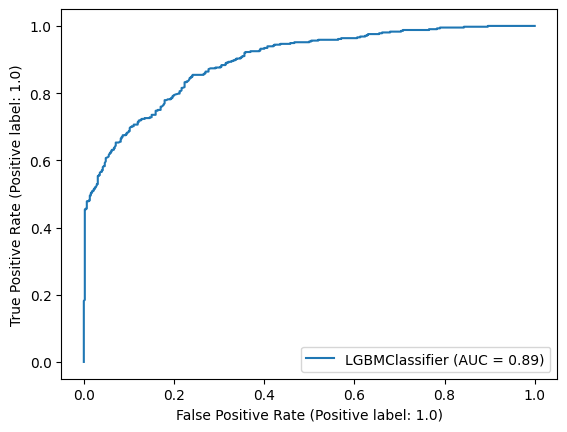

In [115]:
lgbmc_roc = RocCurveDisplay.from_estimator(lgbmc, X_test, y_test)

In [116]:
sub_pred_lgbmc = lgbmc.predict(submission_test)

sub_pred_lgbmc = sub_pred_lgbmc.astype('bool')

In [117]:
N_SPLITS = 5
kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=42)

scores = []

for train_idx, test_idx in kf.split(train):

    X_train, X_test = train.iloc[train_idx], train.iloc[test_idx]
    y_train, y_test = test[train_idx], test[test_idx]
    
    preds = lgbmc.predict(X_test)
    loss = accuracy_score(y_test, preds)
    scores.append(loss)
    accuracy = np.mean(scores)
    
print(f"mean score: {accuracy}\n")

mean score: 0.8208727614977616



## **3.1.2 CatBoost**

In [118]:
cbc = cb.CatBoostClassifier()
cbc.fit(train, test)

Learning rate set to 0.025874
0:	learn: 0.6811528	total: 59.8ms	remaining: 59.7s
1:	learn: 0.6686704	total: 63ms	remaining: 31.4s
2:	learn: 0.6590102	total: 65.7ms	remaining: 21.8s
3:	learn: 0.6483345	total: 68.6ms	remaining: 17.1s
4:	learn: 0.6380247	total: 71.5ms	remaining: 14.2s
5:	learn: 0.6277285	total: 74.1ms	remaining: 12.3s
6:	learn: 0.6179193	total: 76.8ms	remaining: 10.9s
7:	learn: 0.6106206	total: 79.5ms	remaining: 9.86s
8:	learn: 0.6030342	total: 82.4ms	remaining: 9.07s
9:	learn: 0.5941932	total: 84.9ms	remaining: 8.41s
10:	learn: 0.5852734	total: 87.9ms	remaining: 7.9s
11:	learn: 0.5771708	total: 90.5ms	remaining: 7.45s
12:	learn: 0.5708337	total: 93.3ms	remaining: 7.08s
13:	learn: 0.5651194	total: 96.1ms	remaining: 6.77s
14:	learn: 0.5603452	total: 98.9ms	remaining: 6.49s
15:	learn: 0.5553264	total: 102ms	remaining: 6.29s
16:	learn: 0.5505612	total: 105ms	remaining: 6.1s
17:	learn: 0.5451660	total: 109ms	remaining: 5.94s
18:	learn: 0.5403024	total: 112ms	remaining: 5.79s


174:	learn: 0.3852517	total: 582ms	remaining: 2.74s
175:	learn: 0.3850387	total: 585ms	remaining: 2.74s
176:	learn: 0.3845056	total: 588ms	remaining: 2.73s
177:	learn: 0.3842621	total: 591ms	remaining: 2.73s
178:	learn: 0.3839755	total: 594ms	remaining: 2.73s
179:	learn: 0.3836731	total: 597ms	remaining: 2.72s
180:	learn: 0.3834229	total: 600ms	remaining: 2.71s
181:	learn: 0.3830285	total: 607ms	remaining: 2.73s
182:	learn: 0.3827897	total: 609ms	remaining: 2.72s
183:	learn: 0.3825837	total: 612ms	remaining: 2.71s
184:	learn: 0.3823584	total: 618ms	remaining: 2.72s
185:	learn: 0.3820652	total: 621ms	remaining: 2.72s
186:	learn: 0.3818473	total: 624ms	remaining: 2.71s
187:	learn: 0.3816335	total: 628ms	remaining: 2.71s
188:	learn: 0.3811516	total: 630ms	remaining: 2.7s
189:	learn: 0.3808369	total: 633ms	remaining: 2.7s
190:	learn: 0.3804242	total: 637ms	remaining: 2.7s
191:	learn: 0.3802876	total: 640ms	remaining: 2.69s
192:	learn: 0.3801244	total: 643ms	remaining: 2.69s
193:	learn: 0.3

340:	learn: 0.3525676	total: 1.09s	remaining: 2.1s
341:	learn: 0.3523677	total: 1.09s	remaining: 2.1s
342:	learn: 0.3522792	total: 1.09s	remaining: 2.1s
343:	learn: 0.3521973	total: 1.1s	remaining: 2.09s
344:	learn: 0.3520872	total: 1.1s	remaining: 2.09s
345:	learn: 0.3518897	total: 1.1s	remaining: 2.08s
346:	learn: 0.3517619	total: 1.11s	remaining: 2.08s
347:	learn: 0.3514131	total: 1.11s	remaining: 2.08s
348:	learn: 0.3512744	total: 1.11s	remaining: 2.07s
349:	learn: 0.3510242	total: 1.11s	remaining: 2.07s
350:	learn: 0.3507743	total: 1.12s	remaining: 2.07s
351:	learn: 0.3506478	total: 1.12s	remaining: 2.06s
352:	learn: 0.3505267	total: 1.12s	remaining: 2.06s
353:	learn: 0.3504325	total: 1.13s	remaining: 2.06s
354:	learn: 0.3502803	total: 1.13s	remaining: 2.05s
355:	learn: 0.3500236	total: 1.13s	remaining: 2.05s
356:	learn: 0.3498445	total: 1.13s	remaining: 2.04s
357:	learn: 0.3495861	total: 1.14s	remaining: 2.04s
358:	learn: 0.3494491	total: 1.14s	remaining: 2.04s
359:	learn: 0.3492

506:	learn: 0.3261794	total: 1.57s	remaining: 1.53s
507:	learn: 0.3260071	total: 1.58s	remaining: 1.53s
508:	learn: 0.3258874	total: 1.58s	remaining: 1.52s
509:	learn: 0.3255085	total: 1.58s	remaining: 1.52s
510:	learn: 0.3253683	total: 1.59s	remaining: 1.52s
511:	learn: 0.3252674	total: 1.59s	remaining: 1.52s
512:	learn: 0.3251391	total: 1.59s	remaining: 1.51s
513:	learn: 0.3249070	total: 1.6s	remaining: 1.51s
514:	learn: 0.3247113	total: 1.6s	remaining: 1.51s
515:	learn: 0.3246087	total: 1.6s	remaining: 1.5s
516:	learn: 0.3245294	total: 1.61s	remaining: 1.5s
517:	learn: 0.3244246	total: 1.61s	remaining: 1.5s
518:	learn: 0.3242976	total: 1.61s	remaining: 1.5s
519:	learn: 0.3242208	total: 1.62s	remaining: 1.49s
520:	learn: 0.3240963	total: 1.62s	remaining: 1.49s
521:	learn: 0.3239588	total: 1.62s	remaining: 1.49s
522:	learn: 0.3237627	total: 1.63s	remaining: 1.48s
523:	learn: 0.3235894	total: 1.63s	remaining: 1.48s
524:	learn: 0.3234940	total: 1.63s	remaining: 1.48s
525:	learn: 0.32340

666:	learn: 0.3062278	total: 2.05s	remaining: 1.02s
667:	learn: 0.3061318	total: 2.06s	remaining: 1.02s
668:	learn: 0.3059767	total: 2.06s	remaining: 1.02s
669:	learn: 0.3058919	total: 2.06s	remaining: 1.02s
670:	learn: 0.3057947	total: 2.07s	remaining: 1.01s
671:	learn: 0.3056751	total: 2.07s	remaining: 1.01s
672:	learn: 0.3055545	total: 2.07s	remaining: 1.01s
673:	learn: 0.3054221	total: 2.07s	remaining: 1s
674:	learn: 0.3052950	total: 2.08s	remaining: 1s
675:	learn: 0.3051421	total: 2.08s	remaining: 997ms
676:	learn: 0.3050300	total: 2.08s	remaining: 994ms
677:	learn: 0.3048150	total: 2.09s	remaining: 991ms
678:	learn: 0.3047173	total: 2.09s	remaining: 988ms
679:	learn: 0.3046098	total: 2.09s	remaining: 985ms
680:	learn: 0.3045105	total: 2.1s	remaining: 982ms
681:	learn: 0.3043909	total: 2.1s	remaining: 979ms
682:	learn: 0.3042925	total: 2.1s	remaining: 976ms
683:	learn: 0.3041815	total: 2.1s	remaining: 972ms
684:	learn: 0.3040992	total: 2.11s	remaining: 969ms
685:	learn: 0.3040207	

837:	learn: 0.2876378	total: 2.57s	remaining: 497ms
838:	learn: 0.2875654	total: 2.57s	remaining: 494ms
839:	learn: 0.2874130	total: 2.58s	remaining: 491ms
840:	learn: 0.2873371	total: 2.58s	remaining: 487ms
841:	learn: 0.2872444	total: 2.58s	remaining: 484ms
842:	learn: 0.2871197	total: 2.58s	remaining: 481ms
843:	learn: 0.2870272	total: 2.59s	remaining: 478ms
844:	learn: 0.2869251	total: 2.59s	remaining: 475ms
845:	learn: 0.2868238	total: 2.59s	remaining: 472ms
846:	learn: 0.2866978	total: 2.6s	remaining: 469ms
847:	learn: 0.2865974	total: 2.6s	remaining: 466ms
848:	learn: 0.2864682	total: 2.6s	remaining: 463ms
849:	learn: 0.2862694	total: 2.6s	remaining: 460ms
850:	learn: 0.2862139	total: 2.61s	remaining: 457ms
851:	learn: 0.2861506	total: 2.61s	remaining: 454ms
852:	learn: 0.2860560	total: 2.61s	remaining: 451ms
853:	learn: 0.2859737	total: 2.62s	remaining: 447ms
854:	learn: 0.2858611	total: 2.62s	remaining: 444ms
855:	learn: 0.2857853	total: 2.62s	remaining: 441ms
856:	learn: 0.28

999:	learn: 0.2719802	total: 3.05s	remaining: 0us


In [119]:
#Future importance by whole dataset
feature_importance = cbc.get_feature_importance(type="FeatureImportance")
feature_importance

array([5.72756408e+00, 3.91039784e+00, 1.39076520e-01, 5.47141820e+00,
       6.77375740e+00, 3.45360835e+00, 9.32875395e+00, 8.62941967e+00,
       6.29493741e+00, 4.60096582e+00, 4.31030277e+00, 5.31548439e+00,
       9.69178816e-01, 1.05582460e+01, 5.81443065e+00, 3.32638477e+00,
       2.45694714e+00, 6.93169760e-01, 2.11270668e-01, 1.32158147e+00,
       5.18444553e-01, 6.09485719e-01, 2.27286634e+00, 8.81468319e-02,
       3.77158781e+00, 1.25235441e+00, 2.18007376e+00, 1.44852734e-04])

In [120]:
def objective(trial):
# https://practicaldatascience.co.uk/machine-learning/how-to-tune-a-catboostclassifier-model-with-optuna
    params={
    #Parameters to tune
    'iterations' : trial.suggest_int('iterations',100,3000),
    'depth' : trial.suggest_int('depth', 1, 15),    
    'min_data_in_leaf' : trial.suggest_int('min_data_in_leaf', 0, 400),
    
    #Parameters to control overfitting
    'early_stopping_rounds': 10,
    'od_type' : trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
    'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
        
    #Regularization
    'l2_leaf_reg' : trial.suggest_float("l2_leaf_reg", 1e-8, 100.0),
        
    #loss function and evaluation metric
    'objective' : trial.suggest_categorical("objective", ['Logloss', 'CrossEntropy',]),
    'eval_metric' : trial.suggest_categorical('eval_metric', ['AUC', 'Recall', 'Precision','Accuracy']),
    
    #'task_type' : 'GPU,'
    'verbose' : False,
}
    
    
    # Fit the model
    optuna_model = cb.CatBoostClassifier(**params)
    optuna_model.fit(X_train, y_train, eval_set=(X_val, y_val))

    # Make predictions
    y_pred = optuna_model.predict(X_test)

    # Evaluate predictions
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

In [ ]:
%%time
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=200, n_jobs=-1)
    
print('Number of finished trials: {}'.format(len(study.trials)))
print('Best trial:')
trial = study.best_trial

print('  Value: {}'.format(trial.value))
print('  Params: ')

for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

In [ ]:
82.3

In [ ]:
cbc = cb.CatBoostClassifier(**trial.params)

In [ ]:
%%time
cbc.fit(X_train, y_train, eval_set=[(X_val, y_val)])
cbc_pred = cbc.predict(X_test)

In [ ]:
cbc_roc = RocCurveDisplay.from_estimator(cbc, X_test, y_test)

In [ ]:
sub_pred_cbc = xgbc.predict(submission_test)

sub_pred_cbc = sub_pred_cbc.astype('bool')

In [ ]:
N_SPLITS = 5
kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=42)

scores = []

for train_idx, test_idx in kf.split(train):

    X_train, X_test = train.iloc[train_idx], train.iloc[test_idx]
    y_train, y_test = test[train_idx], test[test_idx]
    
    preds = cbc.predict(X_test)
    loss = accuracy_score(y_test, preds)
    scores.append(loss)
    accuracy = np.mean(scores)
    
print(f"mean score: {accuracy}\n")

In [ ]:

# k = 4 tells four top features to be selected
# Score function Chi2 tells the feature to be selected using Chi Square
# test = SelectKBest(score_func=chi2, k=4)
# fit = test.fit(X, y)
# fit.scores_
# X_new=test.fit_transform(X, y)

In [ ]:
sub = pd.read_csv('data/sample_submission.csv')

In [ ]:
sub['Transported'] = sub_pred_cbc

In [ ]:
sub.to_csv('data/submission.csv', index=False)

## **PyTorch**

In [ ]:
# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

In [ ]:
%%time
train_test.reset_index(drop=True, inplace=True)
train = train_test[~train_test.Transported.isnull()].copy().astype('float64')
test = train['Transported'].copy().astype('float64')
train = train.drop(labels=['PassengerId', 'Transported'], axis=1)
submission_test = train_test[train_test.Transported.isnull()].copy()
submission = submission_test.PassengerId.copy()
submission_test = submission_test.drop(labels =['PassengerId', 'Transported'], axis=1)

# Model
class LogisticRegression(torch.nn.Module):
     def __init__(self, input_size, output_size):
         super(LogisticRegression, self).__init__()
         self.linear = torch.nn.Linear(input_size, output_size)
            
     def forward(self, x):
         outputs = torch.sigmoid(self.linear(x))
         return outputs

#Create model
model = LogisticRegression(input_size=X_train.shape[1], output_size=1).to(device)
    
#loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.004)

#k-fold parameters
num_folds = 10
kf = KFold(n_splits=num_folds)

#Cross-Validation scores
scores = []

#Cross-Validation
for train_index, test_index in kf.split(train):
    torch.cuda.synchronize(device)
    X_train, X_test = torch.Tensor(train.iloc[train_index,:].values), torch.Tensor(train.iloc[test_index,:].values)
    y_train, y_test = torch.Tensor(test[train_index].values), torch.Tensor(test[test_index].values)

 # Model Training
    losses = []
    losses_test = []
    Iterations = []
    iter = 0
    epochs = 2000
    for epoch in tqdm(range(int(epochs)),desc='Training Epochs'):
        torch.cuda.synchronize(device)
        x =  X_train.to(device)
        labels =  y_train.to(device)
        optimizer.zero_grad() # Setting our stored gradients equal to zero
        outputs = model(x)
        loss = criterion(torch.squeeze(outputs), labels) 

        loss.backward() # Computes the gradient of the given tensor w.r.t. the weights/bias
        optimizer.step() # Updates weights and biases with the optimizer (SGD)

        iter+=1
        if iter%100==0:
            with torch.no_grad():
                # Calculating the loss and accuracy for the test dataset
                correct_test = 0
                total_test = 0
                outputs_test = torch.squeeze(model(X_test.to(device)))
                loss_test = criterion(outputs_test, y_test.to(device))

                predicted_test = outputs_test.cpu().round().detach().numpy()
                total_test += y_test.size(0)
                correct_test += np.sum(predicted_test == y_test.detach().numpy())
                accuracy_test = 100 * correct_test/total_test
                losses_test.append(loss_test.item())

                # Calculating the loss and accuracy for the train dataset
                total = 0
                correct = 0
                total += y_train.size(0)
                correct += np.sum(torch.squeeze(outputs).cpu().round().detach().numpy() == y_train.detach().numpy())
                accuracy = 100 * correct/total
                losses.append(loss.item())
                Iterations.append(iter)
    
    print(f"Iteration. \nTest - Loss: {loss_test.item()}. Accuracy: {accuracy_test}")
    print(f"Train -  Loss: {loss.item()}. Accuracy: {accuracy}\n")
    scores.append(accuracy_test)
    accuracy = np.mean(scores)
print(f"accuracy score: {accuracy}\n")